# Import and Load

In [1]:
import re
import pandas as pd
from nltk_setup import setup_nltk
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn
from textblob import TextBlob
import numpy as np
from collections import Counter
from nltk import ngrams
from typing import List, Tuple
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import squarify


In [2]:
setup_nltk()

NLTK punkt is already downloaded
NLTK averaged_perceptron_tagger is already downloaded
NLTK stopwords is already downloaded


In [3]:
dg = pd.read_csv('icd11-25_data_clean_with_generated_descriptions.csv')
dg.columns

Index(['id', 'code', 'title', 'browser_url', 'class_kind', 'definition',
       'parent', 'inclusions', 'foundation_children',
       'foundation_child_references', 'index_terms', 'related_entities',
       'full_text', 'children', 'postcoordination_scales',
       'index_term_references', 'exclusions', 'exclusion_references',
       'fully_specified_name', 'generated_description', 'chapter'],
      dtype='object')

In [4]:
dg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13960 entries, 0 to 13959
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           13960 non-null  int64 
 1   code                         13062 non-null  object
 2   title                        13960 non-null  object
 3   browser_url                  13960 non-null  object
 4   class_kind                   13960 non-null  object
 5   definition                   6894 non-null   object
 6   parent                       13960 non-null  int64 
 7   inclusions                   1113 non-null   object
 8   foundation_children          1468 non-null   object
 9   foundation_child_references  1468 non-null   object
 10  index_terms                  10855 non-null  object
 11  related_entities             2287 non-null   object
 12  full_text                    13960 non-null  object
 13  children                     32

# Comparative Analysis

## Pre-processing

In [5]:
def preprocess_text(text, 
                   to_lowercase=True, 
                   remove_punctuation=True, 
                   lemmatize=True,
                   remove_stopwords=True):

    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    if to_lowercase:
        text = text.lower()
    
    # Remove punctuation
    if remove_punctuation:
        text = re.sub(r'[^\w\s]', ' ', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into text
    return ' '.join(tokens)

def create_preprocessed_columns(df, original_col='definition',
                                generated_col='generated_description',
                                to_lowercase=True,
                                remove_punctuation=True,
                                lemmatize=True,
                                remove_stopwords=True):

    # Create a copy of the dataframe
    df_processed = df[['id', 'chapter', original_col, generated_col]].copy()
    
    # Create new column names for preprocessed text
    original_processed = f"{original_col}_processed"
    generated_processed = f"{generated_col}_processed"
    
    # Apply preprocessing to both columns
    df_processed[original_processed] = df_processed[original_col].apply(
        lambda x: preprocess_text(x, 
                                to_lowercase=to_lowercase,
                                remove_punctuation=remove_punctuation,
                                lemmatize=lemmatize,
                                remove_stopwords=remove_stopwords)
    )
    
    df_processed[generated_processed] = df_processed[generated_col].apply(
        lambda x: preprocess_text(x,
                                to_lowercase=to_lowercase,
                                remove_punctuation=remove_punctuation,
                                lemmatize=lemmatize,
                                remove_stopwords=remove_stopwords)
    )
    
    return df_processed

## Quality 

In [6]:
density_df = create_preprocessed_columns(
    dg,
    to_lowercase=True,
    remove_punctuation=True,
    lemmatize=False,
    remove_stopwords=False
)

### Length


Summary Statistics by Chapter Group:
--------------------------------------------------------------------------------

Chapters 1-6:
----------------------------------------

Character Length:
Original descriptions:
count    3136.000000
mean      300.444515
std       331.015981
min         0.000000
25%         0.000000
50%       224.000000
75%       447.000000
max      3654.000000
Name: definition, dtype: float64

Generated descriptions:
count    3136.000000
mean      862.842474
std       381.205759
min       120.000000
25%       640.750000
50%       754.000000
75%       935.250000
max      2638.000000
Name: generated_description, dtype: float64

Ratio (Generated/Original): 2.87

Chapters 7-12:
----------------------------------------

Character Length:
Original descriptions:
count    1986.000000
mean      179.010574
std       223.980229
min         0.000000
25%         0.000000
50%       119.500000
75%       273.750000
max      1507.000000
Name: definition, dtype: float64

Generated 

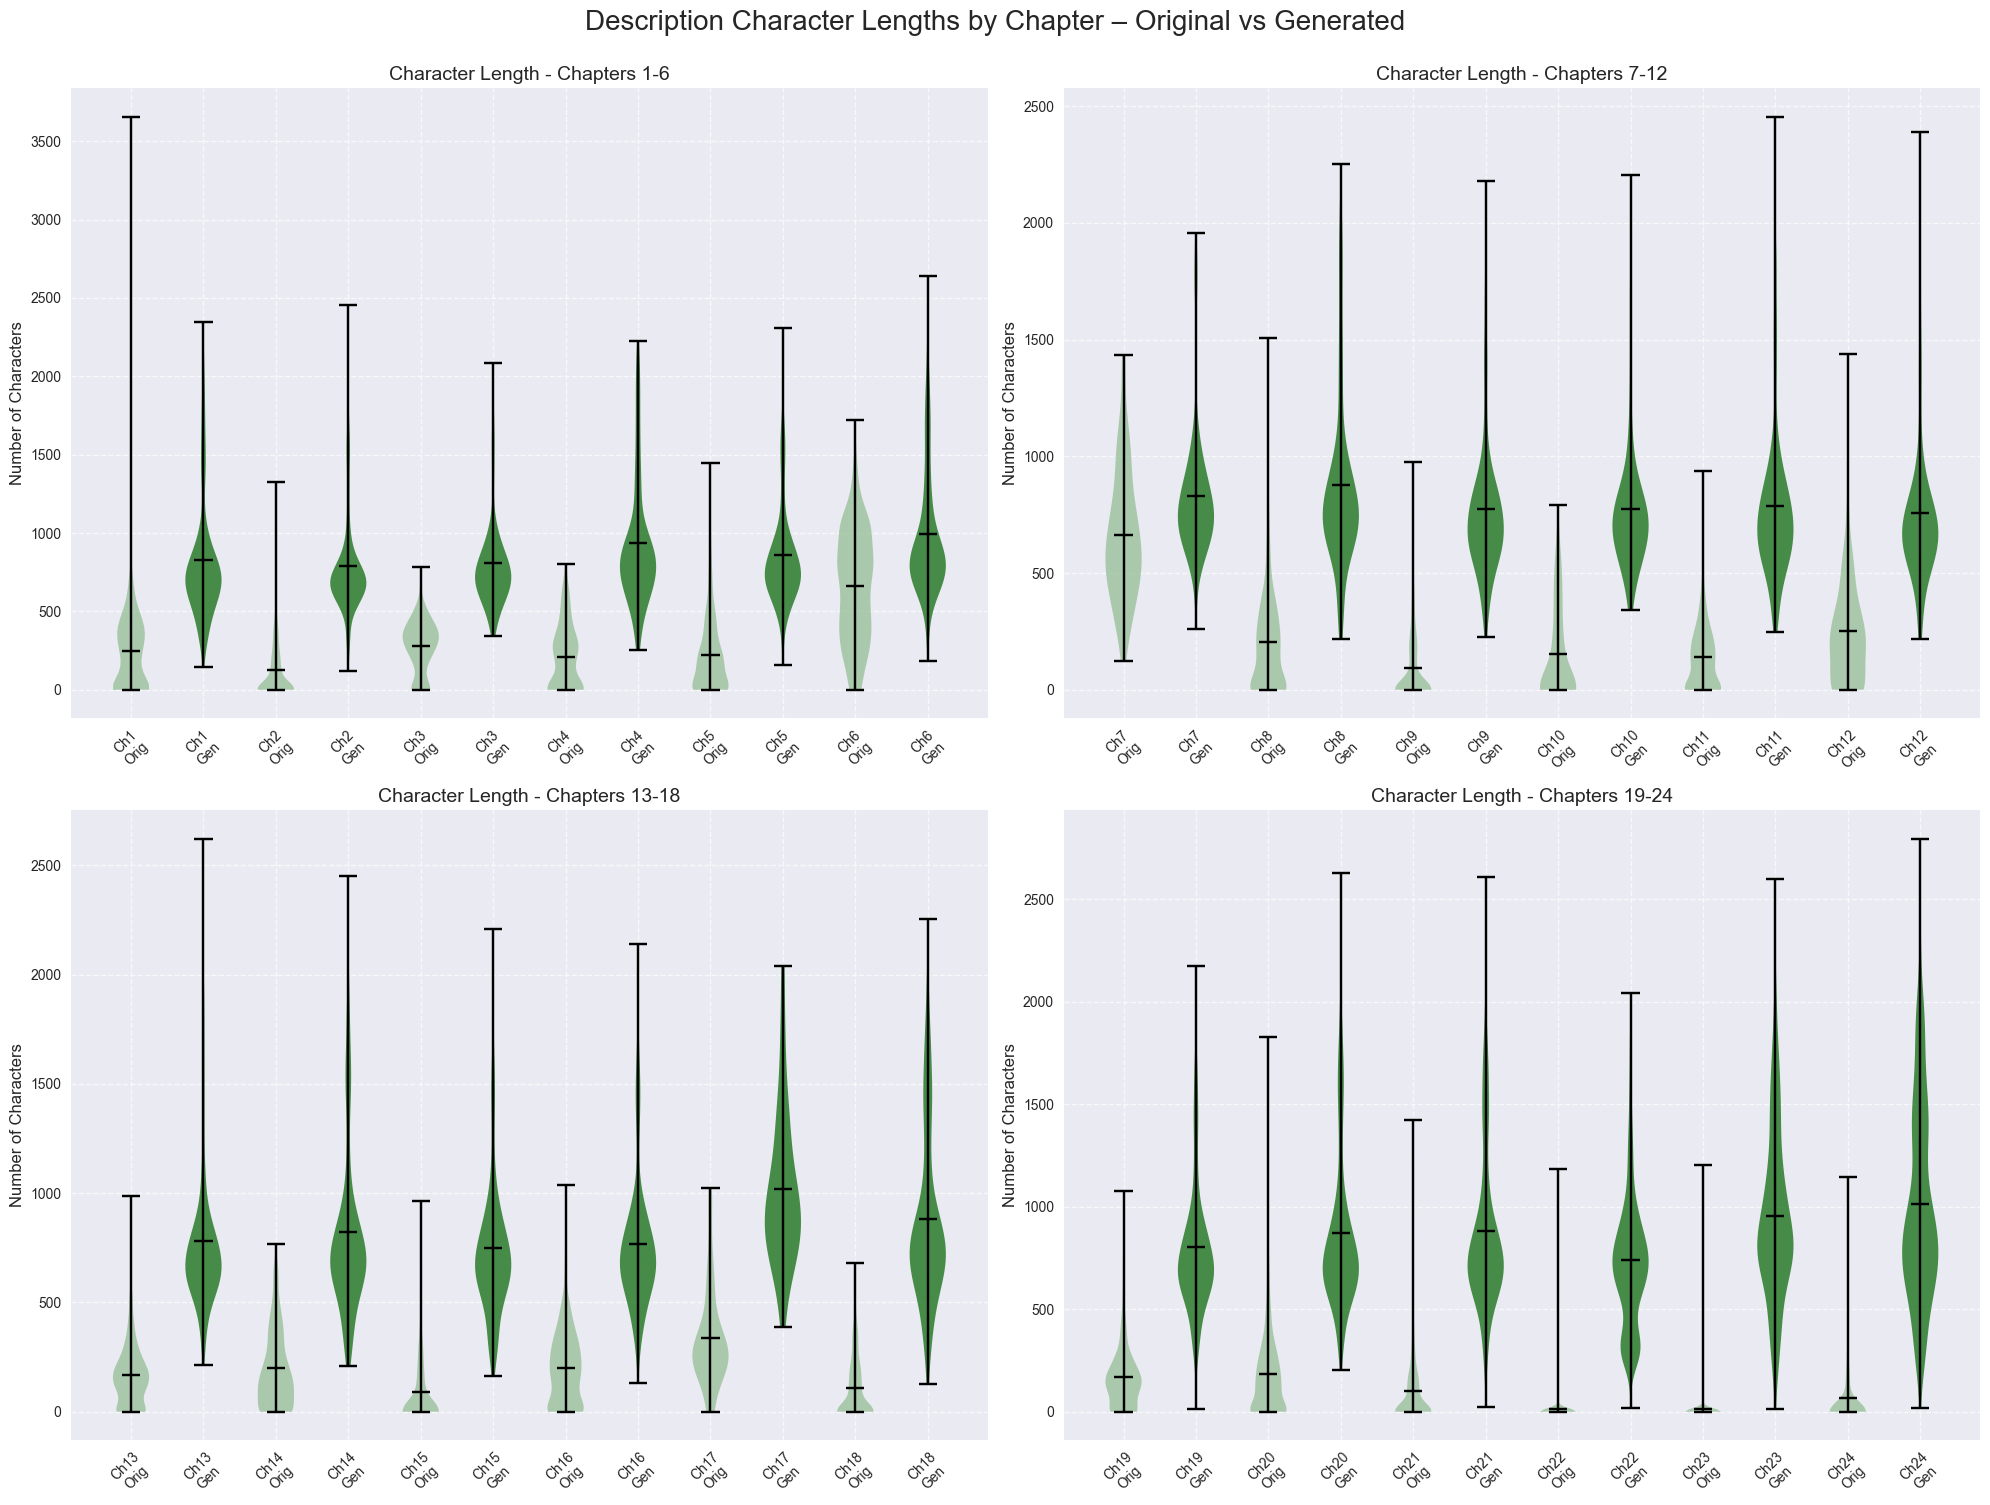

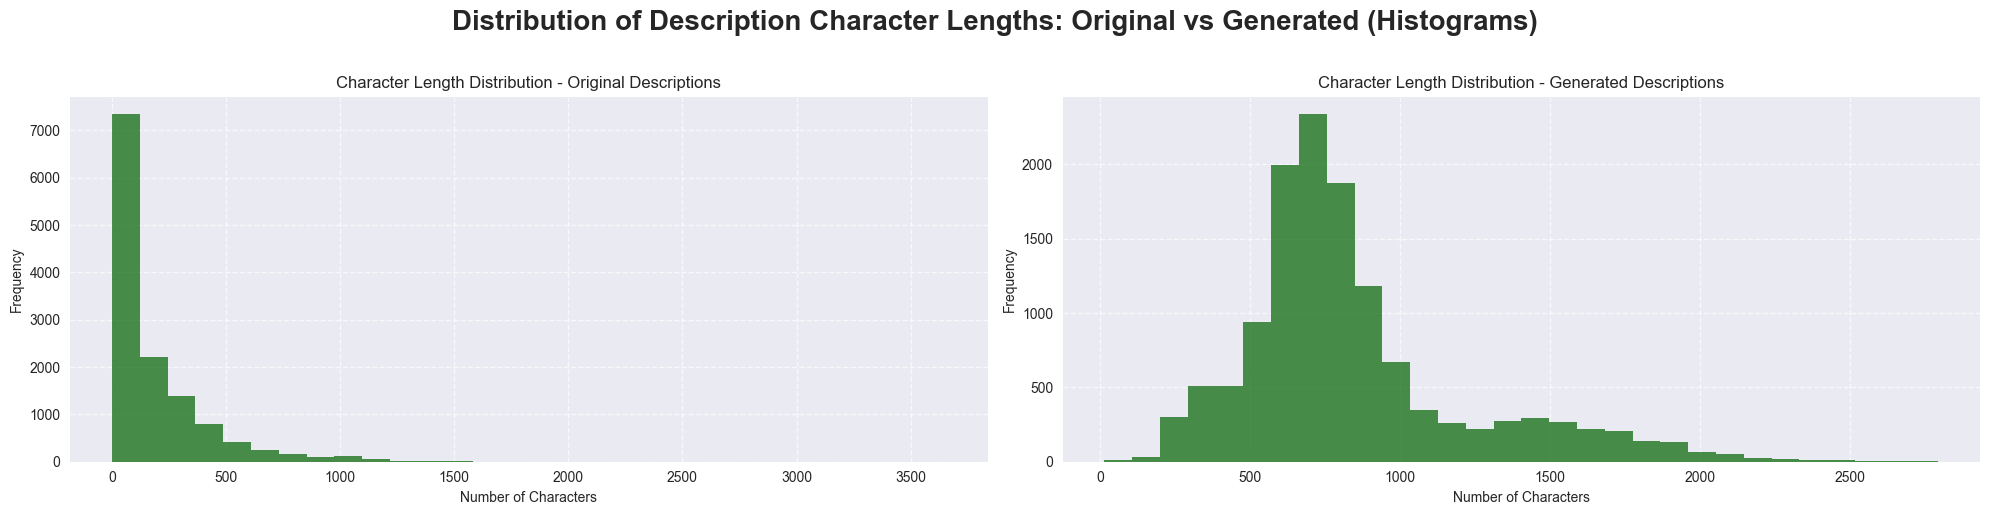

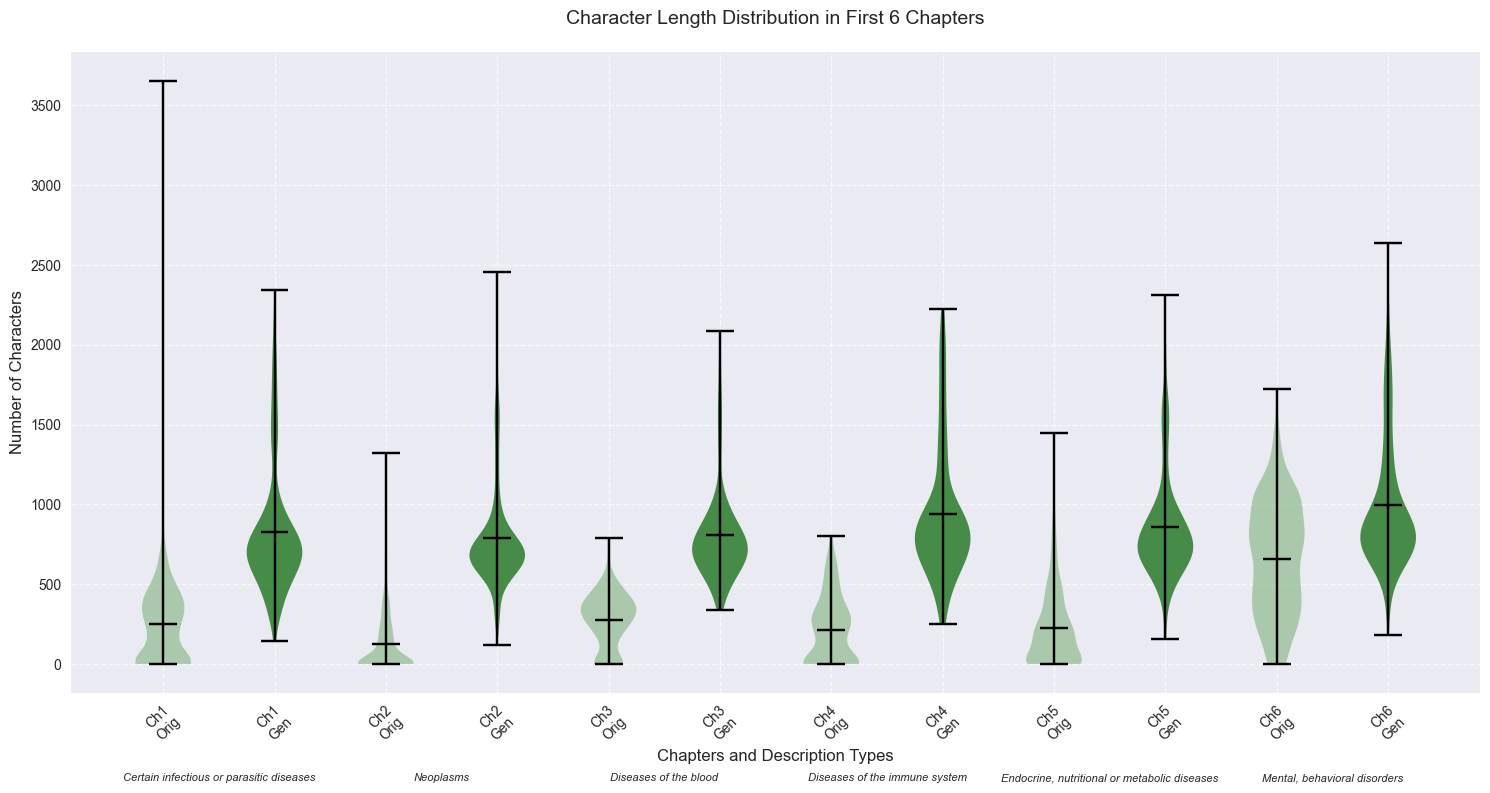

In [24]:
def analyze_description_lengths(df, 
                                original_col='definition',
                                generated_col='generated_description',
                                chapter_col='chapter'):
    """
    Analyze and compare lengths of original and generated descriptions across chapter groups.
    
    Args:
        df (pd.DataFrame): Input dataframe
        original_col (str): Column name for original descriptions
        generated_col (str): Column name for generated descriptions
        chapter_col (str): Column name for chapter information
    """
    # Set the style for all plots
    plt.style.use('seaborn-v0_8')
    colors = ['#8FBC8F', '#006400']  # Light green for original, dark green for generated
    
    # Create chapter groups
    chapter_groups = {
        '1-6': range(1,7),
        '7-12': range(7,13),
        '13-18': range(13,19),
        '19-24': range(19,25)
    }
    
    # Calculate character lengths
    length_func = lambda x: len(str(x))
    
    # Create a figure for violin plots
    fig_violin = plt.figure(figsize=(20, 15))
    gs_violin = fig_violin.add_gridspec(2, 2)
    fig_violin.suptitle('Description Character Lengths by Chapter – Original vs Generated', 
                     fontsize=20, y=1)
    
    # Create a separate figure for histograms
    fig_hist = plt.figure(figsize=(20, 5))
    plt.subplots_adjust(top=0.90)
    gs_hist = fig_hist.add_gridspec(1, 2)
    fig_hist.suptitle('Distribution of Description Character Lengths: Original vs Generated (Histograms)',
                    fontsize=20, fontweight='bold', y=1.02)
    
    # Create a figure for detailed first 6 chapters
    fig_first6 = plt.figure(figsize=(15, 8))
    ax_first6 = fig_first6.add_subplot(111)
 
    
    # Prepare histogram data
    hist_orig_data = []
    hist_gen_data = []
    
    # Create violin plots for each chapter group
    for group_idx, (group_name, chapters) in enumerate(chapter_groups.items()):
        row = group_idx // 2
        col = group_idx % 2
        ax_violin = fig_violin.add_subplot(gs_violin[row, col])
        
        # Prepare data for violin plot
        violin_data = []
        labels = []
        
        # Calculate lengths for each chapter in group
        for chapter in chapters:
            chapter_data = df[df[chapter_col] == chapter]
            
            # Original descriptions
            orig_lengths = chapter_data[original_col].fillna('').apply(length_func)
            violin_data.append(orig_lengths)
            labels.append(f'Ch{chapter}\nOrig')
            hist_orig_data.extend(orig_lengths)
            
            # Generated descriptions
            gen_lengths = chapter_data[generated_col].apply(length_func)
            violin_data.append(gen_lengths)
            labels.append(f'Ch{chapter}\nGen')
            hist_gen_data.extend(gen_lengths)
        
        # Create violin plot
        violin = ax_violin.violinplot(violin_data,
                                    showmeans=True,
                                    showextrema=True)
        
        # Customize violin plot colors
        for i, pc in enumerate(violin['bodies']):
            pc.set_facecolor(colors[i % 2])
            pc.set_alpha(0.7)
        
        # Set violin lines to black
        violin['cmeans'].set_color('black')
        violin['cmaxes'].set_color('black')
        violin['cmins'].set_color('black')
        violin['cbars'].set_color('black')
        
        # Customize violin plot
        ax_violin.set_title(f'Character Length - Chapters {group_name}', fontsize=14)
        ax_violin.set_ylabel('Number of Characters', fontsize=12)
        ax_violin.set_xticks(range(1, len(labels) + 1))
        ax_violin.set_xticklabels(labels, rotation=45)
        ax_violin.grid(True, linestyle='--', alpha=0.7)
    
    # Create detailed violin plot for first 6 chapters
    first6_data = []
    first6_labels = []
    chapter_names = {
        1: "Certain infectious or parasitic diseases",
        2: "Neoplasms",
        3: "Diseases of the blood",
        4: "Diseases of the immune system",
        5: "Endocrine, nutritional or metabolic diseases",
        6: "Mental, behavioral disorders"
    }
    
    for chapter in range(1, 7):
        chapter_data = df[df[chapter_col] == chapter]
        
        # Original descriptions
        orig_lengths = chapter_data[original_col].fillna('').apply(length_func)
        first6_data.append(orig_lengths)
        first6_labels.append(f'Ch{chapter}\nOrig')
        
        # Generated descriptions
        gen_lengths = chapter_data[generated_col].apply(length_func)
        first6_data.append(gen_lengths)
        first6_labels.append(f'Ch{chapter}\nGen')
    
    # Create detailed violin plot
    violin_first6 = ax_first6.violinplot(first6_data, showmeans=True, showextrema=True)
    
    # Customize detailed violin plot
    for i, pc in enumerate(violin_first6['bodies']):
        pc.set_facecolor(colors[i % 2])
        pc.set_alpha(0.7)
    
    violin_first6['cmeans'].set_color('black')
    violin_first6['cmaxes'].set_color('black')
    violin_first6['cmins'].set_color('black')
    violin_first6['cbars'].set_color('black')
    
    # Add chapter names as annotations
    for i in range(0, len(first6_labels), 2):
        chapter_num = (i // 2) + 1
        ax_first6.annotate(chapter_names[chapter_num],
                          xy=(i + 1.5, ax_first6.get_ylim()[0]),
                          xytext=(i + 1.5, ax_first6.get_ylim()[0] - 500),
                          ha='center', va='top',
                          fontsize=8, style='italic',
                          bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    ax_first6.set_title('Character Length Distribution in First 6 Chapters', 
                        fontsize=14, pad=20)
    ax_first6.set_ylabel('Number of Characters', fontsize=12)
    ax_first6.set_xlabel('Chapters and Description Types', fontsize=12)
    ax_first6.set_xticks(range(1, len(first6_labels) + 1))
    ax_first6.set_xticklabels(first6_labels, rotation=45)
    ax_first6.grid(True, linestyle='--', alpha=0.7)
    
    # Create histograms (original and generated separately)
    ax_hist_orig = fig_hist.add_subplot(gs_hist[0, 0])
    ax_hist_gen = fig_hist.add_subplot(gs_hist[0, 1])
    
    # Original descriptions histogram
    ax_hist_orig.hist(hist_orig_data, bins=30, color=colors[1], alpha=0.7)
    ax_hist_orig.set_title('Character Length Distribution - Original Descriptions', fontsize=12)
    ax_hist_orig.set_xlabel('Number of Characters', fontsize=10)
    ax_hist_orig.set_ylabel('Frequency', fontsize=10)
    ax_hist_orig.grid(True, linestyle='--', alpha=0.7)
    
    # Generated descriptions histogram
    ax_hist_gen.hist(hist_gen_data, bins=30, color=colors[1], alpha=0.7)
    ax_hist_gen.set_title('Character Length Distribution - Generated Descriptions', fontsize=12)
    ax_hist_gen.set_xlabel('Number of Characters', fontsize=10)
    ax_hist_gen.set_ylabel('Frequency', fontsize=10)
    ax_hist_gen.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layouts
    fig_violin.tight_layout()
    fig_hist.tight_layout()
    fig_first6.tight_layout()
    
    # Print summary statistics
    print("\nSummary Statistics by Chapter Group:")
    print("-" * 80)
    
    for group_name, chapters in chapter_groups.items():
        print(f"\nChapters {group_name}:")
        print("-" * 40)
        
        group_data = df[df[chapter_col].isin(chapters)]
        
        print("\nCharacter Length:")
        print("Original descriptions:")
        print(group_data[original_col].fillna('').apply(length_func).describe())
        print("\nGenerated descriptions:")
        print(group_data[generated_col].apply(length_func).describe())
        
        # Calculate and print the ratio of generated to original
        orig_mean = group_data[original_col].fillna('').apply(length_func).mean()
        gen_mean = group_data[generated_col].apply(length_func).mean()
        if orig_mean > 0:  # Avoid division by zero
            ratio = gen_mean / orig_mean
            print(f"\nRatio (Generated/Original): {ratio:.2f}")

# Example usage:
analyze_description_lengths(density_df)

In [63]:
def plot_first6_chapters_violin(df, 
                               original_col='definition',
                               generated_col='generated_description',
                               chapter_col='chapter'):
    """
    Create a detailed violin plot for the first 6 chapters, comparing original and generated descriptions.
    
    Args:
        df (pd.DataFrame): Input dataframe
        original_col (str): Column name for original descriptions
        generated_col (str): Column name for generated descriptions
        chapter_col (str): Column name for chapter information
    """
    # Set the style
    plt.style.use('seaborn-v0_8')
    colors = ['#8FBC8F', '#006400']  # Light green for original, dark green for generated
    
    # Chapter names for annotations
    chapter_names = {
        1: "Certain infectious or parasitic diseases",
        2: "Neoplasms",
        3: "Diseases of the blood",
        4: "Diseases of the immune system",
        5: "Endocrine, nutritional or metabolic diseases",
        6: "Mental, behavioral disorders"
    }
    
    # Create figure with more vertical space for title
    fig = plt.figure(figsize=(15, 11))  # Increased height further
    ax = fig.add_subplot(111)
    
    # Prepare data
    violin_data = []
    labels = []
    
    # Calculate lengths for each chapter
    for chapter in range(1, 7):
        chapter_data = df[df[chapter_col] == chapter]
        
        # Original descriptions
        orig_lengths = chapter_data[original_col].fillna('').apply(len)
        violin_data.append(orig_lengths)
        labels.append(f'Ch{chapter}\nOrig')
        
        # Generated descriptions
        gen_lengths = chapter_data[generated_col].apply(len)
        violin_data.append(gen_lengths)
        labels.append(f'Ch{chapter}\nGen')
    
    # Create violin plot
    violin = ax.violinplot(violin_data, showmeans=True, showextrema=True)
    
    # Customize violin plot colors
    for i, pc in enumerate(violin['bodies']):
        pc.set_facecolor(colors[i % 2])
        pc.set_alpha(0.7)
    
    # Set violin lines to black
    violin['cmeans'].set_color('black')
    violin['cmaxes'].set_color('black')
    violin['cmins'].set_color('black')
    violin['cbars'].set_color('black')
    
    # # Add chapter names as annotations with more space and larger font
    # for i in range(0, len(labels), 2):
    #     chapter_num = (i // 2) + 1
    #     ax.annotate(chapter_names[chapter_num],
    #                xy=(i + 1.5, ax.get_ylim()[0]),
    #                xytext=(i + 1.5, ax.get_ylim()[0] - 600),  # Increased spacing
    #                ha='center', va='top',
    #                fontsize=13, style='italic',  # Increased font size
    #                bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
    
    # Customize plot with larger fonts and better spacing
    plt.suptitle('Character Length Distribution in First 6 Chapters', 
                 fontsize=22, y=0.95)  # Adjusted y position and increased size
    ax.set_ylabel('Number of Characters', fontsize=20, labelpad=10)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticks(), fontsize=18)
    ax.set_xlabel('Chapters and Description Types', fontsize=20, labelpad=10)
    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation=45, fontsize=18, ha='right')
    ax.tick_params(axis='y', labelsize=18)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend with larger font
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=colors[0], alpha=0.7, label='Original'),
        Patch(facecolor=colors[1], alpha=0.7, label='Generated')
    ]
    ax.legend(handles=legend_elements, 
             loc='upper center',
             bbox_to_anchor=(0.5, -0.15),
             ncol=2,
             fontsize=20)
    
    # Adjust layout to prevent text cutoff
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Give more space for title
    return fig, ax

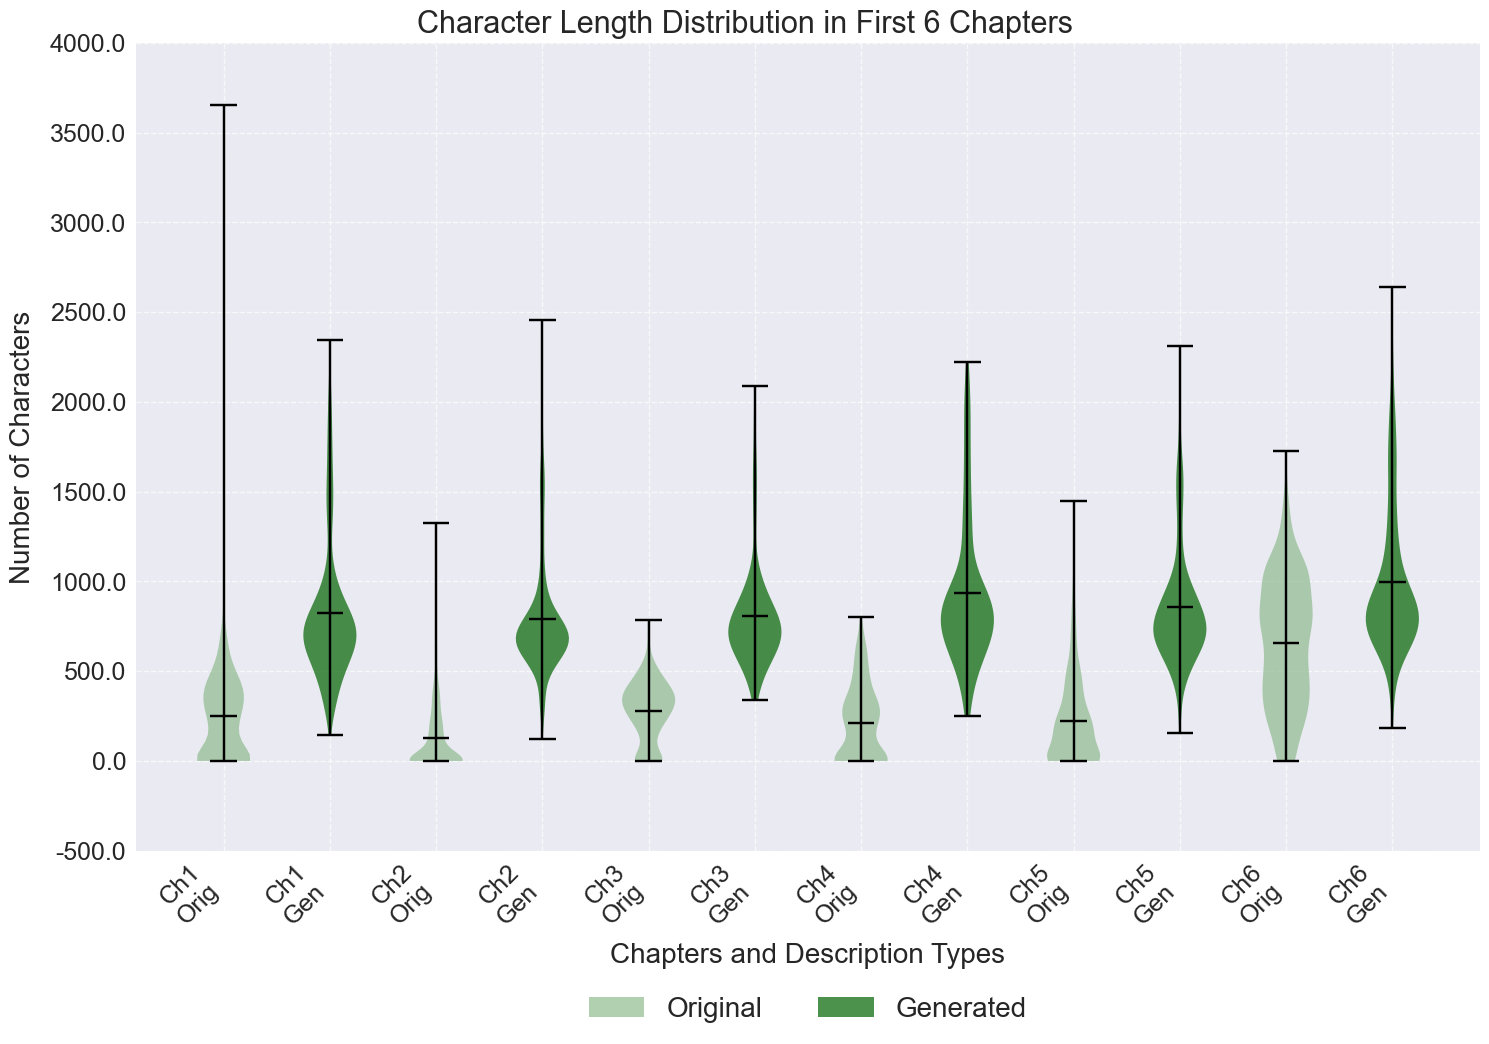

In [64]:
fig, ax = plot_first6_chapters_violin(density_df)
plt.show()

### Vocabolary Richness / Complexity

In [59]:
def calculate_vocabulary_richness(text):
    """
    Calculate Type-Token Ratio and Lexical Diversity for a text.
    
    Args:
        text (str): Input text
        
    Returns:
        tuple: (TTR, Lexical Diversity)
    """
    if not isinstance(text, str):
        return 0, 0
    
    # Tokenize and clean
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]  # Remove non-alphabetic tokens
    
    if not tokens:
        return 0, 0
    
    # Calculate metrics
    unique_words = len(set(tokens))
    total_words = len(tokens)
    
    # Type-Token Ratio
    ttr = unique_words / total_words if total_words > 0 else 0
    
    # Lexical Diversity (unique words per 1000 words)
    lexical_diversity = (unique_words / total_words) * 1000 if total_words > 0 else 0
    
    return ttr, lexical_diversity

def calculate_complexity(text):
    """
    Calculate Flesch-Kincaid Score and Medical Term Density.
    
    Args:
        text (str): Input text
        
    Returns:
        tuple: (Flesch-Kincaid Score, Medical Term Density)
    """
    if not isinstance(text, str):
        return 0, 0
    
    # Calculate Flesch-Kincaid Score
    blob = TextBlob(text)
    sentences = blob.sentences
    words = blob.words
    
    if not sentences or not words:
        return 0, 0
    
    # Flesch-Kincaid formula
    avg_sentence_length = len(words) / len(sentences)
    avg_syllables = sum(len(word) / 3 for word in words) / len(words)  # Approximate syllables
    flesch_kincaid = 0.39 * avg_sentence_length + 11.8 * avg_syllables - 15.59
    
    # Medical Term Density (approximation using word length > 8 as medical terms)
    medical_terms = sum(1 for word in words if len(word) > 8)
    medical_density = medical_terms / len(words) if words else 0
    
    return flesch_kincaid, medical_density

def analyze_chapter_metrics(df, 
                          original_col='definition',
                          generated_col='generated_description',
                          chapter_col='chapter'):
    """
    Analyze metrics across chapters.
    
    Args:
        df (pd.DataFrame): Input dataframe
        original_col (str): Column name for original descriptions
        generated_col (str): Column name for generated descriptions
        chapter_col (str): Column name for chapter information
    """
    # Set style
    plt.style.use('seaborn-v0_8')
    colors = ['#8FBC8F', '#006400']  # Dark green and lighter green
    
    # Initialize data storage
    chapter_metrics = {
        'TTR': {'original': [], 'generated': []},
        'Lexical_Diversity': {'original': [], 'generated': []},
        'Flesch_Kincaid': {'original': [], 'generated': []},
        'Medical_Density': {'original': [], 'generated': []}
    }
    
    # Calculate metrics for each chapter
    for chapter in sorted(df[chapter_col].unique()):
        chapter_data = df[df[chapter_col] == chapter]
        
        # Original descriptions
        orig_texts = chapter_data[original_col].fillna('')
        orig_ttr = [calculate_vocabulary_richness(text)[0] for text in orig_texts]
        orig_lex = [calculate_vocabulary_richness(text)[1] for text in orig_texts]
        orig_fk, orig_md = zip(*[calculate_complexity(text) for text in orig_texts])
        
        # Generated descriptions
        gen_texts = chapter_data[generated_col]
        gen_ttr = [calculate_vocabulary_richness(text)[0] for text in gen_texts]
        gen_lex = [calculate_vocabulary_richness(text)[1] for text in gen_texts]
        gen_fk, gen_md = zip(*[calculate_complexity(text) for text in gen_texts])
        
        # Store metrics
        chapter_metrics['TTR']['original'].append(np.mean(orig_ttr))
        chapter_metrics['TTR']['generated'].append(np.mean(gen_ttr))
        chapter_metrics['Lexical_Diversity']['original'].append(np.mean(orig_lex))
        chapter_metrics['Lexical_Diversity']['generated'].append(np.mean(gen_lex))
        chapter_metrics['Flesch_Kincaid']['original'].append(np.mean(orig_fk))
        chapter_metrics['Flesch_Kincaid']['generated'].append(np.mean(gen_fk))
        chapter_metrics['Medical_Density']['original'].append(np.mean(orig_md))
        chapter_metrics['Medical_Density']['generated'].append(np.mean(gen_md))
    
    # Create separate visualizations
    metrics = ['TTR', 'Lexical_Diversity', 'Flesch_Kincaid', 'Medical_Density']
    titles = ['Type-Token Ratio', 'Lexical Diversity', 'Flesch-Kincaid Score', 'Medical Term Density']
    
    for metric, title in zip(metrics, titles):
        plt.figure(figsize=(12, 8))
        
        x = np.arange(len(df[chapter_col].unique()))
        width = 0.35
        
        plt.bar(x - width/2, chapter_metrics[metric]['original'], 
               width, label='Original', color=colors[0], alpha=0.7)
        plt.bar(x + width/2, chapter_metrics[metric]['generated'], 
               width, label='Generated', color=colors[1], alpha=0.7)
        
        plt.title(title, fontsize=22, y=1)  # Increased font size and centered vertically
        plt.xlabel('Chapter', fontsize=20)  # Increased font size
        plt.ylabel('Score', fontsize=20)  # Increased font size
        plt.xticks(x, sorted(df[chapter_col].unique()), rotation=45, fontsize=18)  # Increased font size
        plt.yticks(fontsize=18)  # Increased font size
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Add legend with no padding
        plt.legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
        
        plt.tight_layout()
        plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics by Metric:")
    print("-" * 80)
    
    for metric, title in zip(metrics, titles):
        print(f"\n{title}:")
        print("Original descriptions:")
        print(f"Mean: {np.mean(chapter_metrics[metric]['original']):.3f}")
        print(f"Std: {np.std(chapter_metrics[metric]['original']):.3f}")
        print("\nGenerated descriptions:")
        print(f"Mean: {np.mean(chapter_metrics[metric]['generated']):.3f}")
        print(f"Std: {np.std(chapter_metrics[metric]['generated']):.3f}")
        
        # Calculate and print the ratio
        ratio = np.mean(chapter_metrics[metric]['generated']) / np.mean(chapter_metrics[metric]['original'])
        print(f"\nRatio (Generated/Original): {ratio:.2f}")

def analyze_vocabulary_complexity(df, 
                                original_col='definition',
                                generated_col='generated_description',
                                chapter_col='chapter'):
    """
    Main pipeline for vocabulary richness and complexity analysis.
    
    Args:
        df (pd.DataFrame): Input dataframe
        original_col (str): Column name for original descriptions
        generated_col (str): Column name for generated descriptions
        chapter_col (str): Column name for chapter information
    """
    # Analyze chapter-wise metrics
    analyze_chapter_metrics(df, original_col, generated_col, chapter_col)

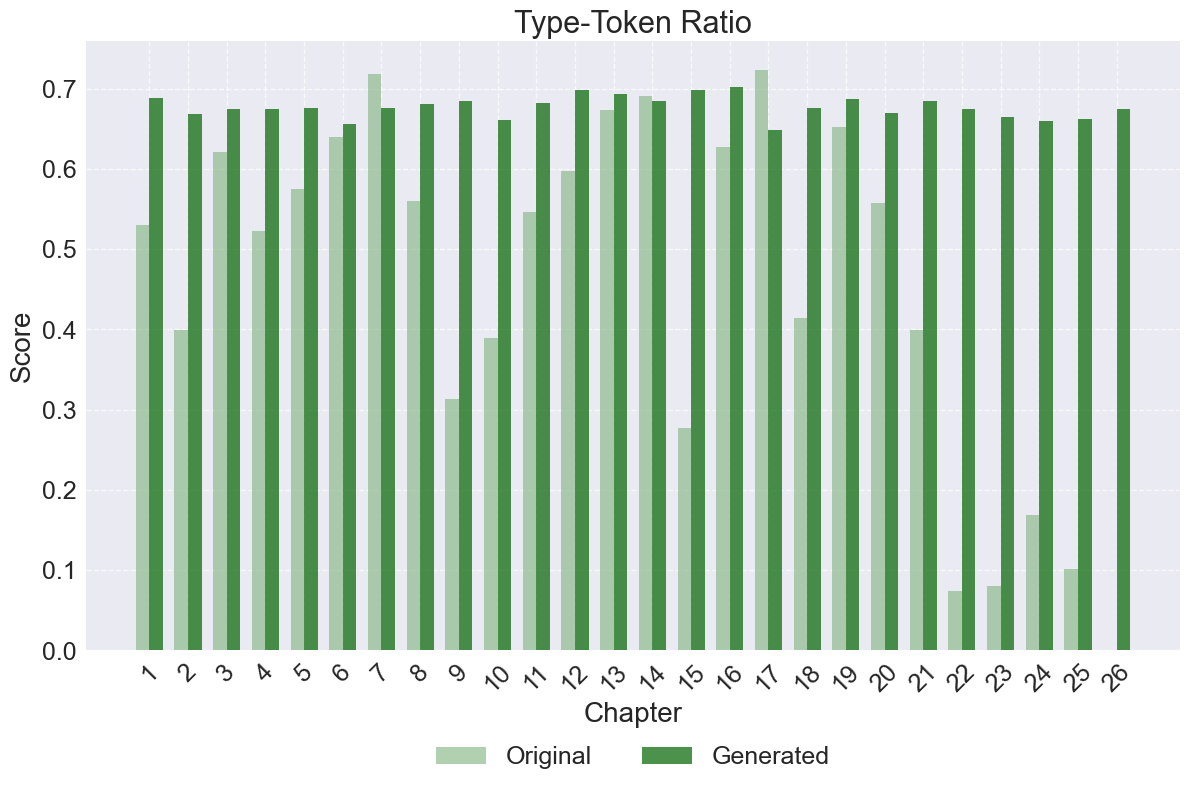

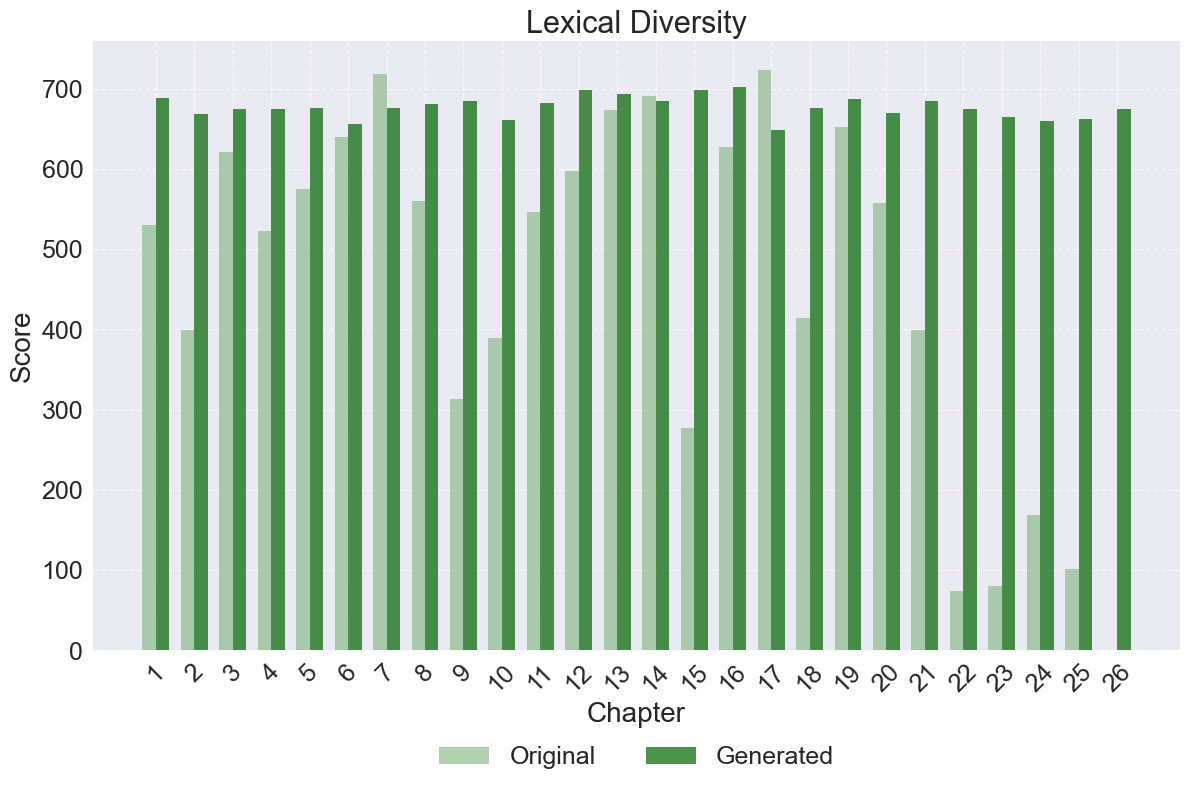

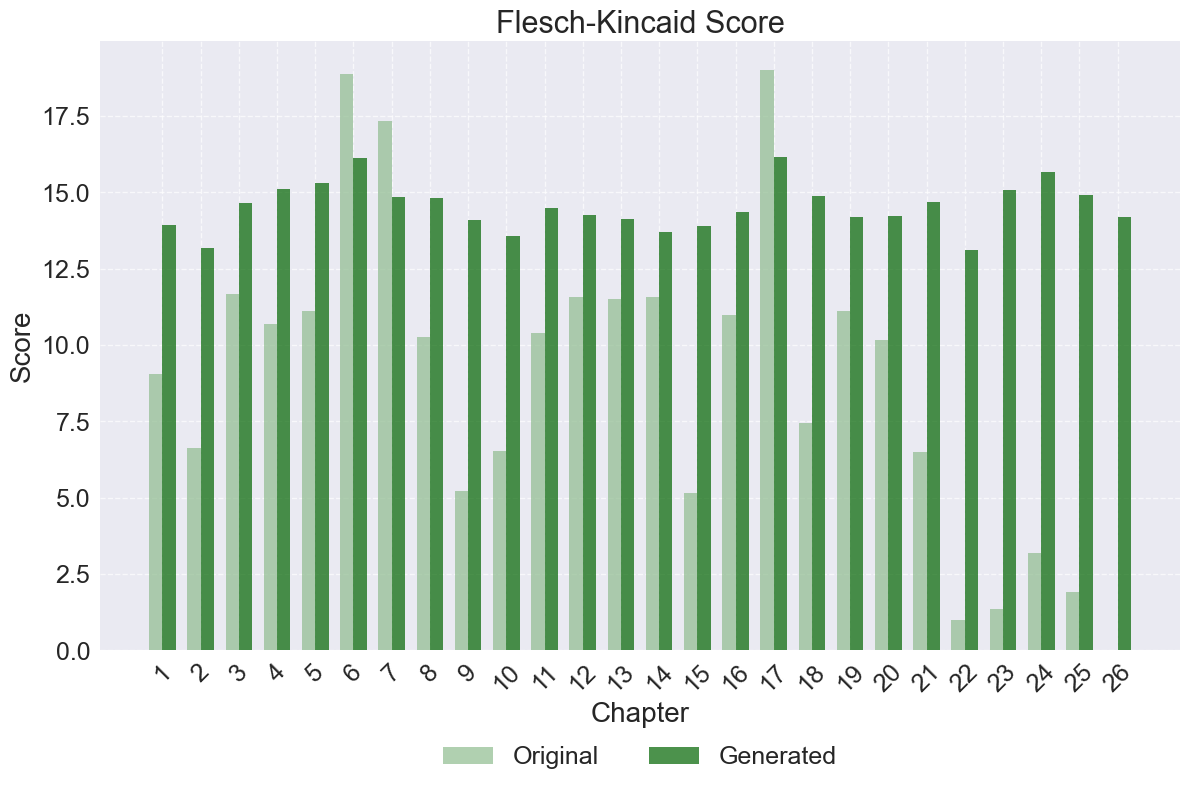

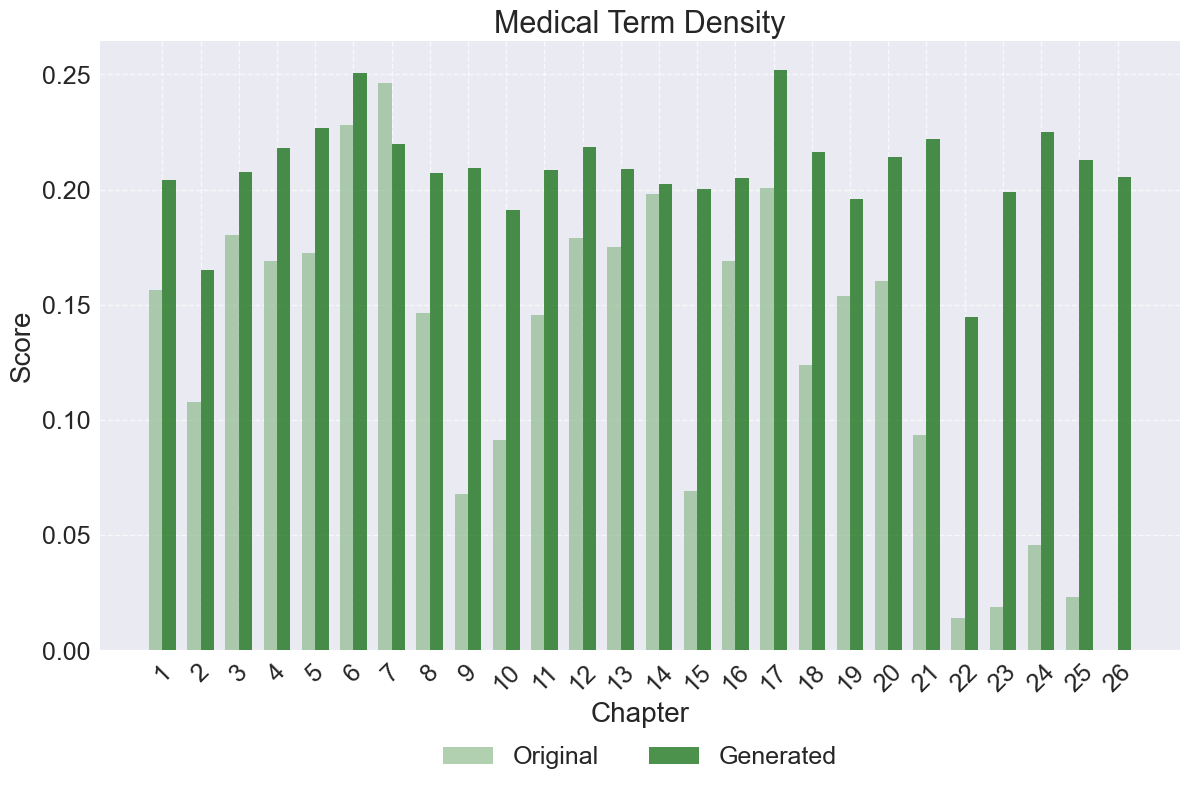


Summary Statistics by Metric:
--------------------------------------------------------------------------------

Type-Token Ratio:
Original descriptions:
Mean: 0.456
Std: 0.216

Generated descriptions:
Mean: 0.677
Std: 0.013

Ratio (Generated/Original): 1.48

Lexical Diversity:
Original descriptions:
Mean: 455.735
Std: 215.926

Generated descriptions:
Mean: 676.738
Std: 13.229

Ratio (Generated/Original): 1.48

Flesch-Kincaid Score:
Original descriptions:
Mean: 8.853
Std: 5.002

Generated descriptions:
Mean: 14.519
Std: 0.768

Ratio (Generated/Original): 1.64

Medical Term Density:
Original descriptions:
Mean: 0.128
Std: 0.068

Generated descriptions:
Mean: 0.209
Std: 0.021

Ratio (Generated/Original): 1.63


In [60]:
analyze_vocabulary_complexity(density_df)

### POS

In [68]:
def pos_analysis_pipeline(df, original_col='definition', generated_col='generated_description', chapter_col='chapter'):
    """
    Analyzes and visualizes POS distribution in original and generated descriptions.
    - Compares overall POS proportions between original and generated.
    - For generated, compares POS proportions across chapters.
    """

    nltk.download('punkt', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    
    # Define POS groups and colors
    pos_map = {
        'Noun': ['NN', 'NNS', 'NNP', 'NNPS'],
        'Verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
        'Adjective': ['JJ', 'JJR', 'JJS'],
        'Adverb': ['RB', 'RBR', 'RBS']
    }
    pos_colors = {
        'Noun': '#FF6F61',      # Coral red
        'Verb': '#D2B48C',      # Tan
        'Adjective': '#AE65D6', # Lavender
        'Adverb': '#598A4F',    # Pale Green
    }
    pos_types = list(pos_map.keys())

    def get_pos_counts(text):
        if not isinstance(text, str) or not text.strip():
            return Counter()
        tokens = nltk.word_tokenize(text)
        tags = nltk.pos_tag(tokens)
        counts = Counter()
        for _, tag in tags:
            found = False
            for pos_name, tag_list in pos_map.items():
                if tag in tag_list:
                    counts[pos_name] += 1
                    found = True
                    break
        return counts

    # # --- 1. Overall POS Proportion Comparison (Stacked Bar) ---
    # orig_counts = Counter()
    # gen_counts = Counter()
    # orig_total = 0
    # gen_total = 0

    # for text in df[original_col].dropna():
    #     c = get_pos_counts(text)
    #     orig_counts += c
    #     orig_total += sum(c.values())
    # for text in df[generated_col].dropna():
    #     c = get_pos_counts(text)
    #     gen_counts += c
    #     gen_total += sum(c.values())

    # orig_props = [orig_counts.get(pos, 0) / orig_total if orig_total else 0 for pos in pos_types]
    # gen_props = [gen_counts.get(pos, 0) / gen_total if gen_total else 0 for pos in pos_types]

    # # Prepare data for stacked bar
    # proportions = np.array([orig_props, gen_props])
    # labels = ['Original', 'Generated']

    # fig, ax = plt.subplots(figsize=(16, 12))
    # bottom = np.zeros(len(labels))
    # for i, pos in enumerate(pos_types):
    #     ax.bar(labels, proportions[:, i], bottom=bottom, color=pos_colors[pos], label=pos)
    #     bottom += proportions[:, i]
    # ax.set_ylabel('Proportion', fontsize=18)
    # ax.set_title('Overall POS Proportion: Original vs Generated', fontsize=22, pad=15)
    # ax.grid(axis='y', linestyle='--', alpha=0.5)
    # ax.tick_params(axis='both', labelsize=18)
    # # Legend at the bottom
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, frameon=False, fontsize=20)
    # # plt.subplots_adjust(bottom=0.2)  # Make room for legend at bottom
    # plt.tight_layout()
    # plt.show()

    # --- 2. Generated Descriptions: POS by Chapter (Stacked Bar) ---
    chapters = sorted(df[chapter_col].unique())
    chapter_props = {pos: [] for pos in pos_types}
    for chapter in chapters:
        chapter_texts = df[df[chapter_col] == chapter][generated_col].dropna()
        chapter_counts = Counter()
        chapter_total = 0
        for text in chapter_texts:
            c = get_pos_counts(text)
            chapter_counts += c
            chapter_total += sum(c.values())
        for pos in pos_types:
            prop = chapter_counts.get(pos, 0) / chapter_total if chapter_total else 0
            chapter_props[pos].append(prop)

    # Prepare data for stacked bar
    proportions = np.array([chapter_props[pos] for pos in pos_types])
    fig, ax = plt.subplots(figsize=(15, 11))
    bottom = np.zeros(len(chapters))
    for i, pos in enumerate(pos_types):
        ax.bar(chapters, proportions[i], bottom=bottom, color=pos_colors[pos], label=pos)
        bottom += proportions[i]
    ax.set_ylabel('Proportion', fontsize=18)
    ax.set_yticklabels(ax.get_yticks(), fontsize=18)
    ax.set_xlabel('Chapter', fontsize=18)
    ax.set_xticklabels(ax.get_xticks(), fontsize=18)
    ax.set_title('POS Proportion in Generated Descriptions by Chapter', fontsize=22, pad=15)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', labelsize=18)
    # Legend at the bottom
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, frameon=False, fontsize=20)
    plt.subplots_adjust(top=0.95)  # Make room for legend at bottom
    plt.tight_layout()
    plt.show()

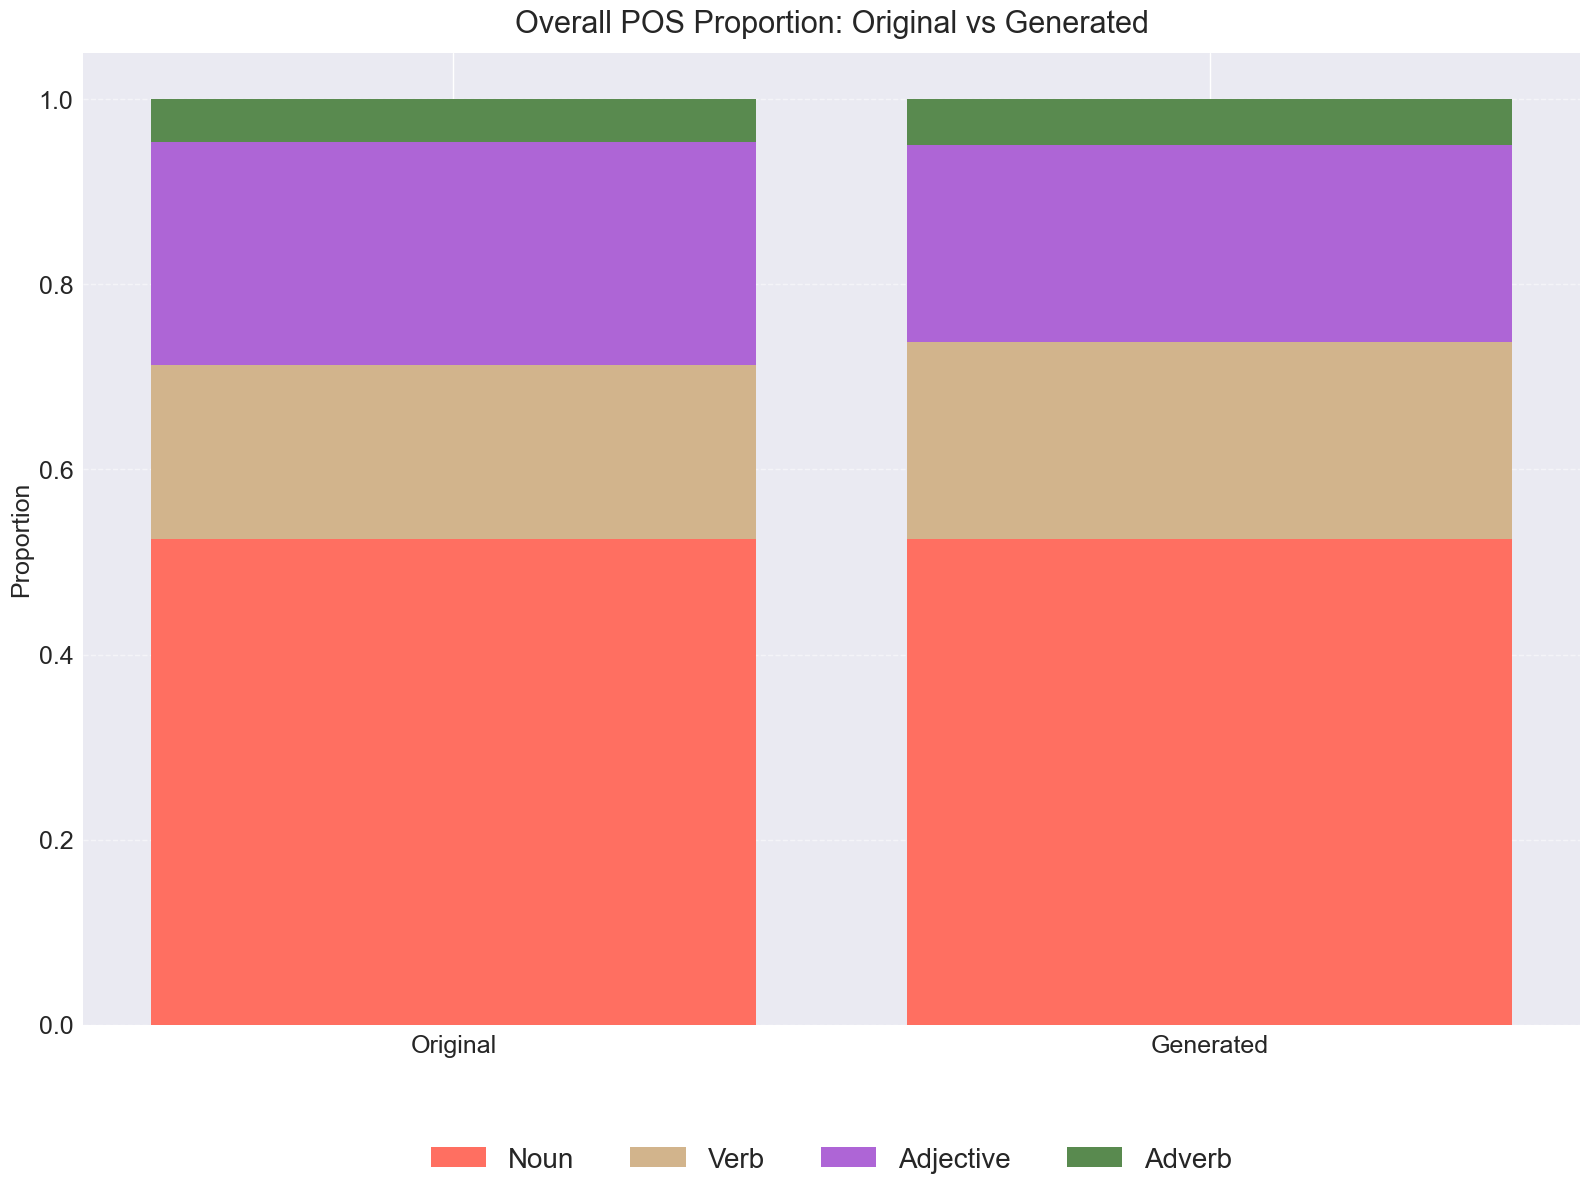

/var/folders/7g/y1r4j5314tj34x7tn5g1cdg80000gn/T/ipykernel_22759/2679254276.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=18)
/var/folders/7g/y1r4j5314tj34x7tn5g1cdg80000gn/T/ipykernel_22759/2679254276.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=18)


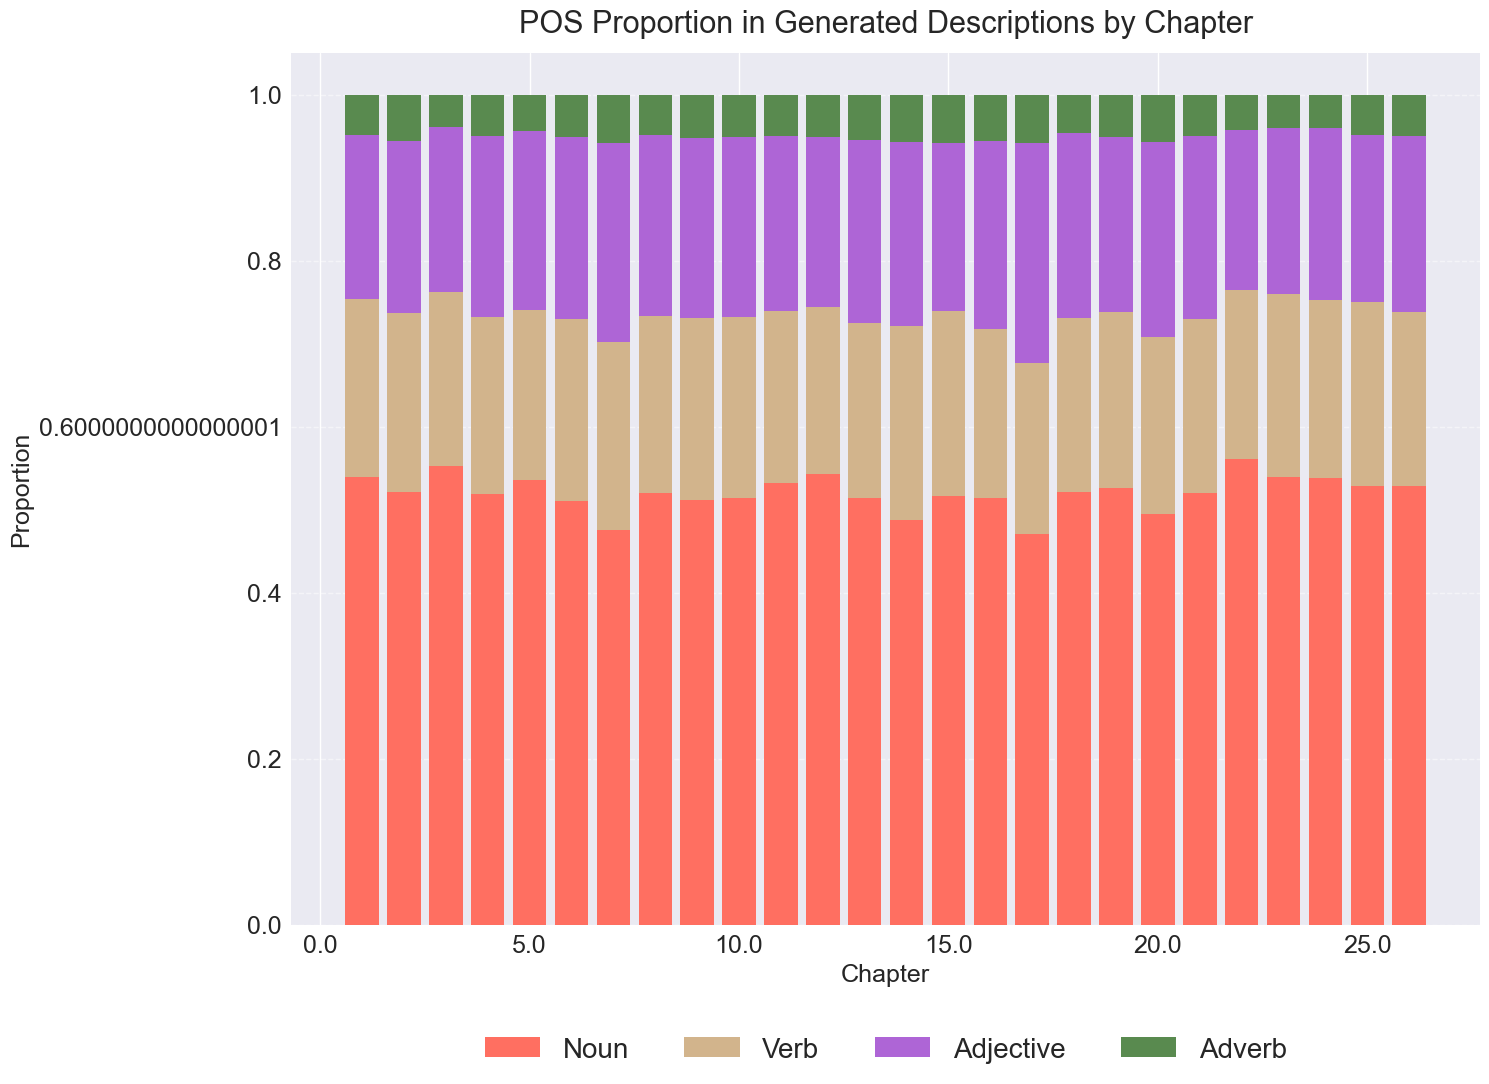

In [69]:
pos_analysis_pipeline(density_df)

In [70]:
def pos_analysis_pipeline(df, original_col='definition', generated_col='generated_description', chapter_col='chapter'):
    """
    Analyzes and visualizes POS distribution in original and generated descriptions.
    - Compares overall POS proportions between original and generated.
    - For generated, compares POS proportions across chapters.
    """

    nltk.download('punkt', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    
    # Define POS groups and colors
    pos_map = {
        'Noun': ['NN', 'NNS', 'NNP', 'NNPS'],
        'Verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
        'Adjective': ['JJ', 'JJR', 'JJS'],
        'Adverb': ['RB', 'RBR', 'RBS']
    }
    pos_colors = {
        'Noun': '#FF6F61',      # Coral red
        'Verb': '#D2B48C',      # Tan
        'Adjective': '#AE65D6', # Lavender
        'Adverb': '#598A4F',    # Pale Green
    }
    pos_types = list(pos_map.keys())

    def get_pos_counts(text):
        if not isinstance(text, str) or not text.strip():
            return Counter()
        tokens = nltk.word_tokenize(text)
        tags = nltk.pos_tag(tokens)
        counts = Counter()
        for _, tag in tags:
            found = False
            for pos_name, tag_list in pos_map.items():
                if tag in tag_list:
                    counts[pos_name] += 1
                    found = True
                    break
        return counts

    # --- 2. Generated Descriptions: POS by Chapter (Stacked Bar) ---
    chapters = sorted(df[chapter_col].unique())
    chapter_props = {pos: [] for pos in pos_types}
    for chapter in chapters:
        chapter_texts = df[df[chapter_col] == chapter][generated_col].dropna()
        chapter_counts = Counter()
        chapter_total = 0
        for text in chapter_texts:
            c = get_pos_counts(text)
            chapter_counts += c
            chapter_total += sum(c.values())
        for pos in pos_types:
            prop = chapter_counts.get(pos, 0) / chapter_total if chapter_total else 0
            chapter_props[pos].append(prop)

    # Prepare data for stacked bar
    proportions = np.array([chapter_props[pos] for pos in pos_types])
    fig, ax = plt.subplots(figsize=(15, 11))
    bottom = np.zeros(len(chapters))
    for i, pos in enumerate(pos_types):
        ax.bar(chapters, proportions[i], bottom=bottom, color=pos_colors[pos], label=pos)
        bottom += proportions[i]
    
    # Set y-axis ticks to 1 decimal point
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    
    # Set x-axis ticks to be continuous and tilted
    ax.set_xticks(range(1, 27))
    ax.set_xticklabels(range(1, 27), rotation=45, ha='right')
    
    ax.set_ylabel('Proportion', fontsize=18)
    ax.set_xlabel('Chapter', fontsize=18)
    ax.set_title('POS Proportion in Generated Descriptions by Chapter', fontsize=22, pad=15)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', labelsize=18)
    # Legend at the bottom
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, frameon=False, fontsize=20)
    plt.subplots_adjust(top=0.95)  # Make room for legend at bottom
    plt.tight_layout()
    plt.show()

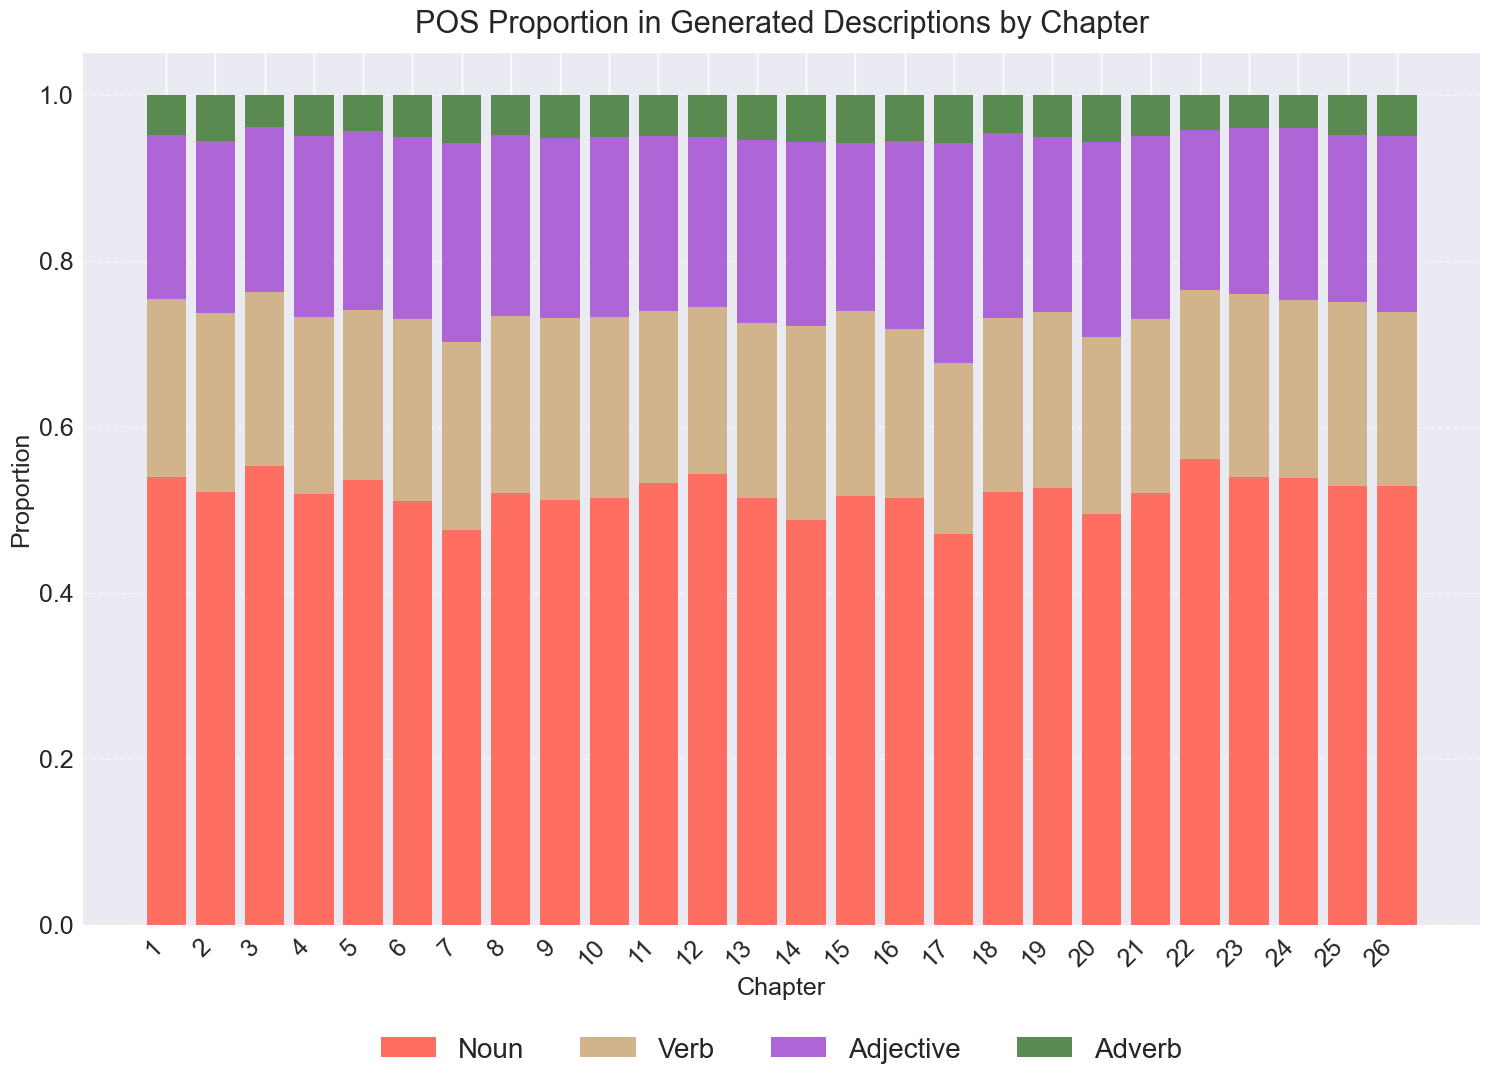

In [71]:
pos_analysis_pipeline(density_df)

## Overlap

In [72]:
# For n-gram overlap, BLEU/ROUGE, and topic modeling
overlap_df = create_preprocessed_columns(
    dg,
    to_lowercase=True,
    remove_punctuation=True,
    lemmatize=True,
    remove_stopwords=True
)

### N-gram

In [73]:
def calculate_ngram_overlap(text1: str, text2: str, n: int = 2) -> float:
    """
    Calculate the overlap score between two texts using n-grams.
    
    Args:
        text1: First text to compare (preprocessed)
        text2: Second text to compare (preprocessed) 
        n: Size of n-grams (default=2 for bigrams)
    
    Returns:
        float: Overlap score between 0 and 1
    """
    # Handle NaN/float values
    if pd.isna(text1) or pd.isna(text2):
        return None
        
    text1 = str(text1)
    text2 = str(text2)
    
    # Skip empty texts
    if not text1.strip() or not text2.strip():
        return None
    
    # Create n-grams directly since text is already preprocessed
    tokens1 = word_tokenize(text1)
    tokens2 = word_tokenize(text2)
    
    ngrams1 = set(ngrams(tokens1, n))
    ngrams2 = set(ngrams(tokens2, n))
    
    # Calculate Jaccard similarity
    if not ngrams1 or not ngrams2:
        return None
    
    intersection = len(ngrams1.intersection(ngrams2))
    union = len(ngrams1.union(ngrams2))
    
    return intersection / union if union > 0 else None

def analyze_ngram_overlap(df: pd.DataFrame, n_values: List[int] = [1, 2, 3]) -> pd.DataFrame:
    """
    Analyze n-gram overlap between original definitions and generated descriptions.
    
    Args:
        df: DataFrame containing preprocessed 'definition', 'generated_description', and 'chapter' columns
        n_values: List of n-gram sizes to analyze
    
    Returns:
        DataFrame with overlap scores by chapter and n-gram size
    """
    # Set plot style
    plt.style.use('seaborn-v0_8')
    colors = ['#8FBC8F', '#006400', '#2E8B57']
    
    # Calculate overlap scores for each n-gram size
    results = []
    for n in n_values:
        df[f'overlap_{n}'] = df.apply(
            lambda row: calculate_ngram_overlap(
                row['definition_processed'], 
                row['generated_description_processed'], 
                n
            ), 
            axis=1
        )
    
    # Group by chapter and calculate mean overlap scores, skipping None values
    chapter_overlaps = df.groupby('chapter').agg(
        {f'overlap_{n}': lambda x: x.dropna().mean() for n in n_values}
    ).reset_index()
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(chapter_overlaps['chapter']))
    width = 0.25
    
    colors_ngrams = ['#FF6B6B', '#4ECDC4', '#FFD93D']

    for i, n in enumerate(n_values):
        plt.bar(
            x + i*width,
            chapter_overlaps[f'overlap_{n}'],
            width,
            label=f'{n}-gram',
            color=colors[i % len(colors_ngrams)]
        )
    
    plt.xlabel('Chapter', fontsize=12)
    plt.ylabel('Mean Overlap Score', fontsize=12)
    plt.title('N-gram Overlap Between Original and Generated Descriptions by Chapter', 
              fontsize=14, pad=20)
    plt.xticks(x + width, chapter_overlaps['chapter'], rotation=45, ha='right')
    plt.legend(title='N-gram Size')
    plt.tight_layout()
    
    return chapter_overlaps

def plot_overlap_distribution(df: pd.DataFrame, n: int = 2):
    """
    Plot the distribution of overlap scores for a specific n-gram size.
    
    Args:
        df: DataFrame with overlap scores
        n: N-gram size to plot
    """
    plt.figure(figsize=(10, 6))
    
    sns.histplot(
        data=df.dropna(subset=[f'overlap_{n}']),
        x=f'overlap_{n}',
        bins=30,
        color='#006400',
        edgecolor='#000000'
    )
    
    plt.xlabel(f'{n}-gram Overlap Score', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f'Distribution of {n}-gram Overlap Scores', fontsize=14, pad=20)
    plt.tight_layout()

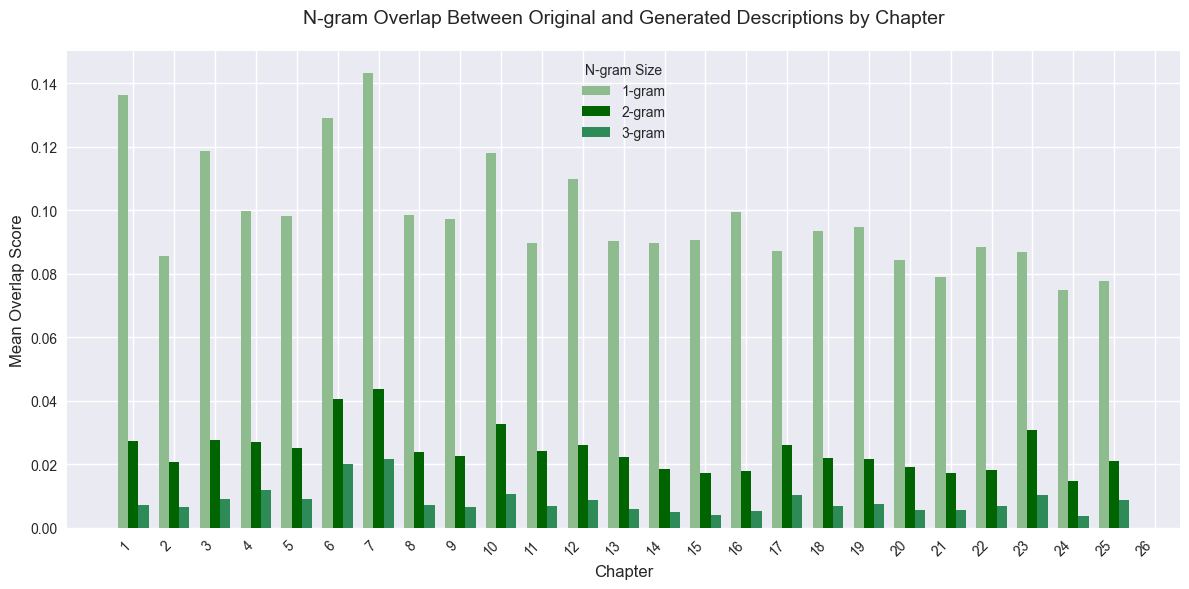

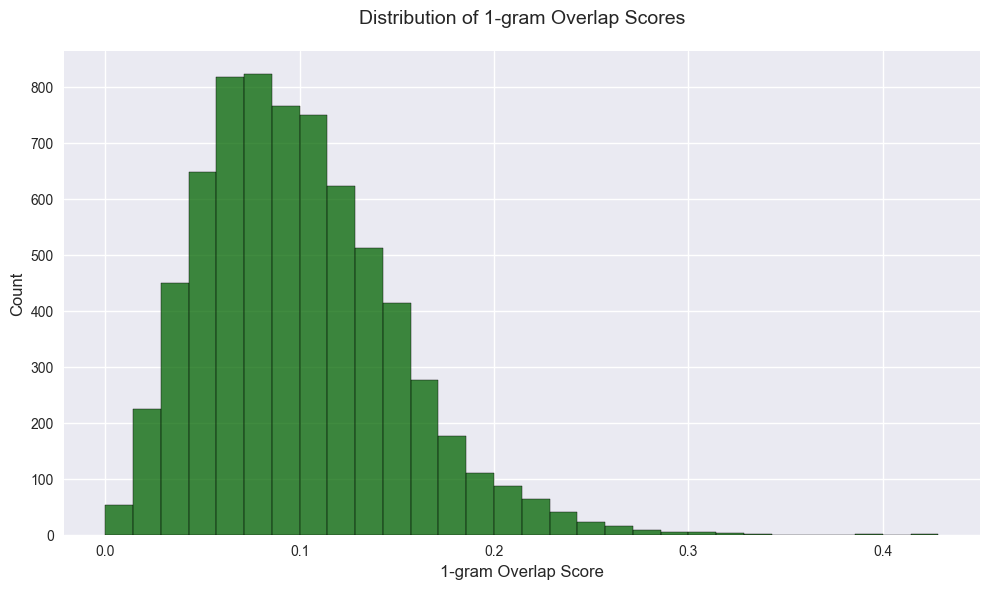

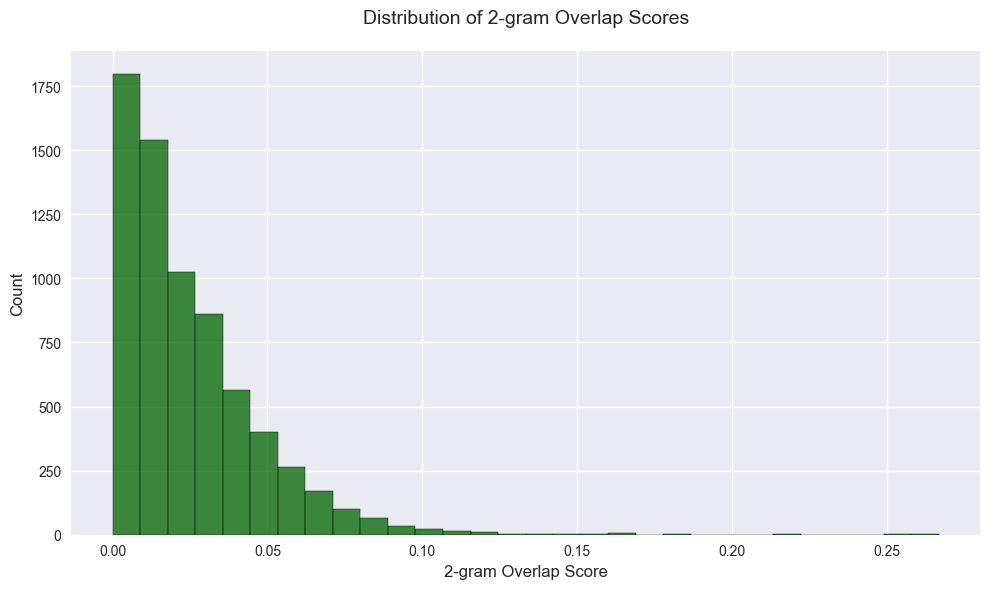

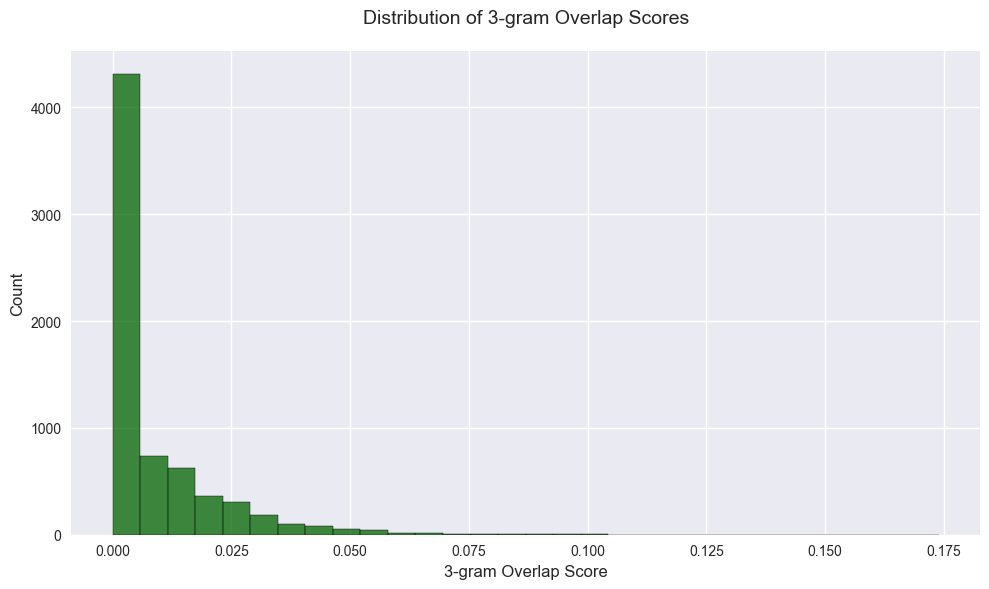

In [116]:
overlap_results = analyze_ngram_overlap(overlap_df, n_values=[1, 2, 3])
plot_overlap_distribution(overlap_df, n=1)
plot_overlap_distribution(overlap_df, n=2)
plot_overlap_distribution(overlap_df, n=3)

### BLUE/ROUGE Score

In [79]:
def calculate_bleu_rouge(reference: str, hypothesis: str) -> dict:
    """
    Calculate BLEU and ROUGE scores between two texts.
    
    Args:
        reference: The reference text (original definition)
        hypothesis: The hypothesis text (generated description)
    
    Returns:
        dict: BLEU and ROUGE scores
    """
    # Handle NaN/float values
    if pd.isna(reference) or pd.isna(hypothesis):
        return {'bleu': None, 'rouge1': None, 'rougeL': None}
    
    reference = str(reference)
    hypothesis = str(hypothesis)
    
    # Skip empty texts
    if not reference.strip() or not hypothesis.strip():
        return {'bleu': None, 'rouge1': None, 'rougeL': None}
    
    # BLEU score
    ref_tokens = [reference.split()]
    hyp_tokens = hypothesis.split()
    bleu = sentence_bleu(ref_tokens, hyp_tokens, smoothing_function=SmoothingFunction().method1)
    
    # ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    rouge1 = scores['rouge1'].fmeasure
    rougeL = scores['rougeL'].fmeasure
    
    return {'bleu': bleu, 'rouge1': rouge1, 'rougeL': rougeL}

def analyze_bleu_rouge(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze BLEU and ROUGE scores between original definitions and generated descriptions.
    
    Args:
        df: DataFrame containing preprocessed 'definition', 'generated_description', and 'chapter' columns
    
    Returns:
        DataFrame with mean BLEU and ROUGE scores by chapter
    """
    # Set plot style
    plt.style.use('seaborn-v0_8')
    colors = ['#598A4F', '#D2B48C', '#FF6F61']
    
    # Calculate BLEU and ROUGE scores row by row
    scores = df.apply(
        lambda row: calculate_bleu_rouge(row['definition_processed'], row['generated_description_processed']),
        axis=1, result_type='expand'
    )
    df = pd.concat([df, scores], axis=1)
    
    # Group by chapter and calculate mean scores, skipping None values
    chapter_scores = df.groupby('chapter').agg({
        'bleu': lambda x: x.dropna().mean(),
        'rouge1': lambda x: x.dropna().mean(),
        'rougeL': lambda x: x.dropna().mean()
    }).reset_index()
    
    # Plot results
    plt.figure(figsize=(15, 10))
    x = np.arange(len(chapter_scores['chapter']))
    width = 0.25
    
    plt.bar(x, chapter_scores['bleu'], width, label='BLEU', color=colors[0])
    plt.bar(x + width, chapter_scores['rouge1'], width, label='ROUGE-1', color=colors[1])
    plt.bar(x + 2*width, chapter_scores['rougeL'], width, label='ROUGE-L', color=colors[2])
    
    plt.xlabel('Chapter', fontsize=20)
    plt.ylabel('Mean Score', fontsize=20)
    plt.title('BLEU and ROUGE Scores Between Original and Generated Descriptions by Chapter', 
              fontsize=22, pad=40)
    plt.xticks(x + width, chapter_scores['chapter'], rotation=45, ha='right', fontsize=18)
    plt.yticks(fontsize=18)
    
    # Move legend to bottom and center it
    plt.legend(title='Score Type', bbox_to_anchor=(0.5, -0.3), loc='center', 
              ncol=3, fontsize=20, title_fontsize=20)
    
    plt.tight_layout()
    
    return chapter_scores

,chapter,bleu,rouge1,rougeL
0,1,0.018871,0.234153,0.164956
1,2,0.016073,0.158583,0.123665
2,3,0.021680,0.226320,0.164071
3,4,0.025177,0.191278,0.142512
4,5,0.019676,0.184305,0.141488
5,6,0.047377,0.266023,0.186221
6,7,0.053970,0.287306,0.208322
7,8,0.017127,0.182458,0.138292
8,9,0.015881,0.178341,0.137422
9,10,0.027180,0.215278,0.155202


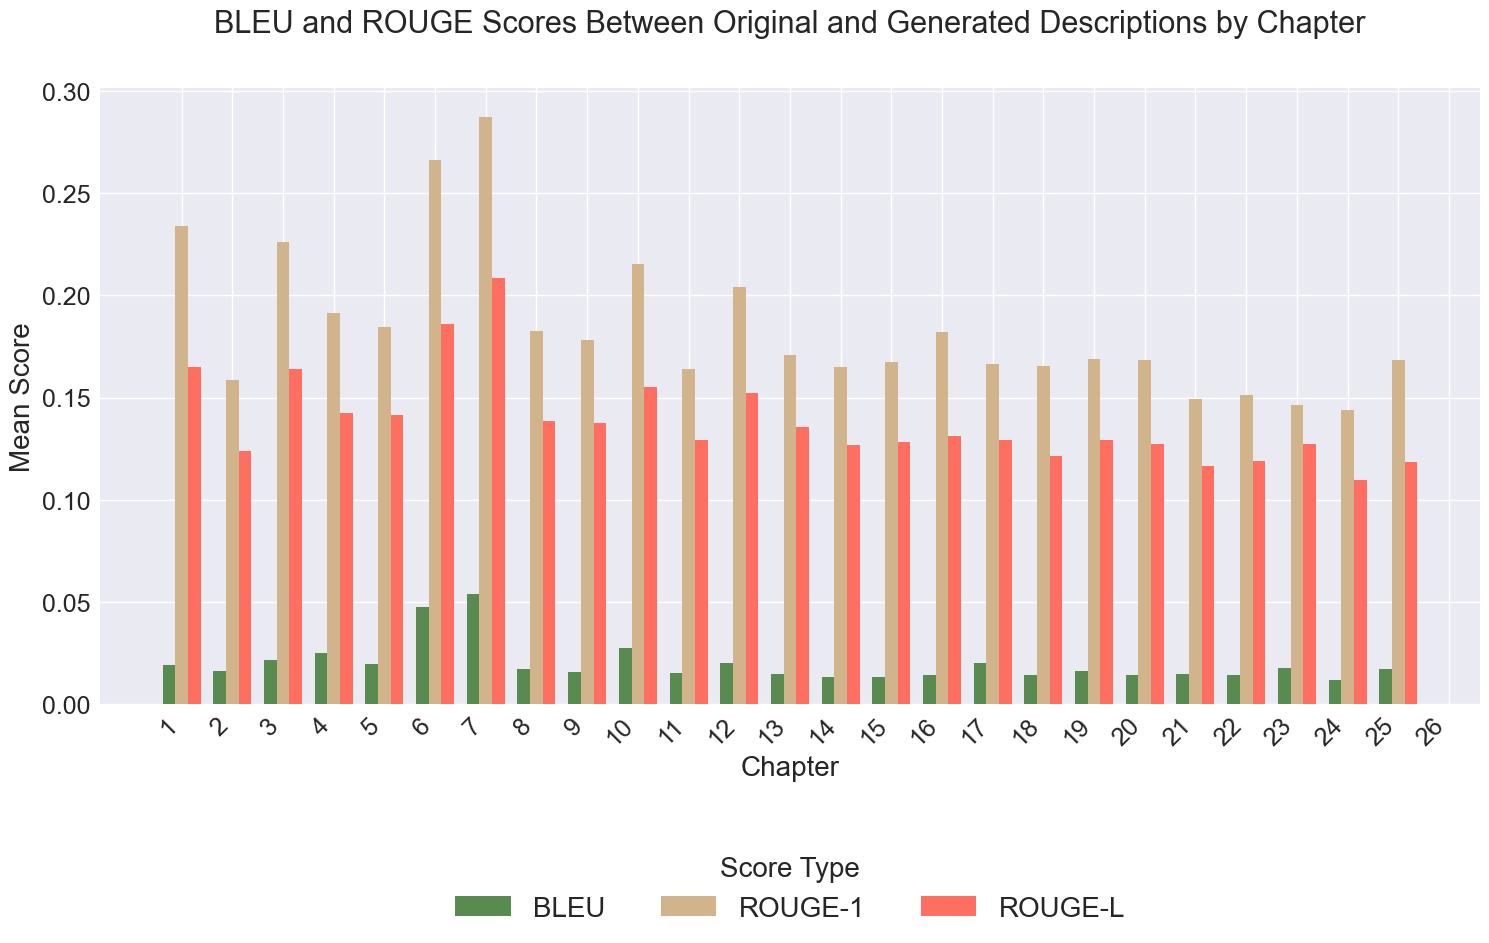

In [80]:
analyze_bleu_rouge(overlap_df)

## Content

In [81]:
# For NER and sentiment analysis
content_df = density_df

### Sentiment

In [88]:
def compute_sentiment(text: str) -> float:
    """
    Compute sentiment polarity of a text using TextBlob.
    
    Args:
        text: The input text (generated description)
    
    Returns:
        float: Sentiment polarity score (-1 to 1)
    """
    if pd.isna(text):
        return None
    text = str(text)
    if not text.strip():
        return None
    return TextBlob(text).sentiment.polarity

def analyze_sentiment_generated(df: pd.DataFrame, column = 'generated_description_processed') -> pd.DataFrame:
    """
    Compute sentiment polarity for generated descriptions and plot histogram by chapter.
    
    Args:
        df: DataFrame containing 'generated_description' and 'chapter' columns
    
    Returns:
        DataFrame with mean sentiment by chapter
    """
    # Set plot style
    plt.style.use('seaborn-v0_8')
    colors = ['#598A4F', '#D2B48C', '#FF6F61']
    
    # Compute sentiment for each row
    df['sentiment'] = df[column].apply(compute_sentiment)
    
    # Group by chapter and calculate mean sentiment, skipping None values
    chapter_sentiment = df.groupby('chapter').agg({
        'sentiment': lambda x: x.dropna().mean()
    }).reset_index()
    
    # Plot histogram of sentiment scores for all generated descriptions
    plt.figure(figsize=(15, 10))
    sns.histplot(
        data=df.dropna(subset=['sentiment']),
        x='sentiment',
        bins=30,
        color=colors[0],
        edgecolor='#000000',
        alpha=1.0
    )
    plt.xlabel('Sentiment Polarity', fontsize=20)
    plt.ylabel('Count', fontsize=20)
    plt.title('Sentiment Distribution of Generated Descriptions', fontsize=22, pad=40)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    # Move legend to bottom and center it
    plt.tight_layout()
    
    return chapter_sentiment

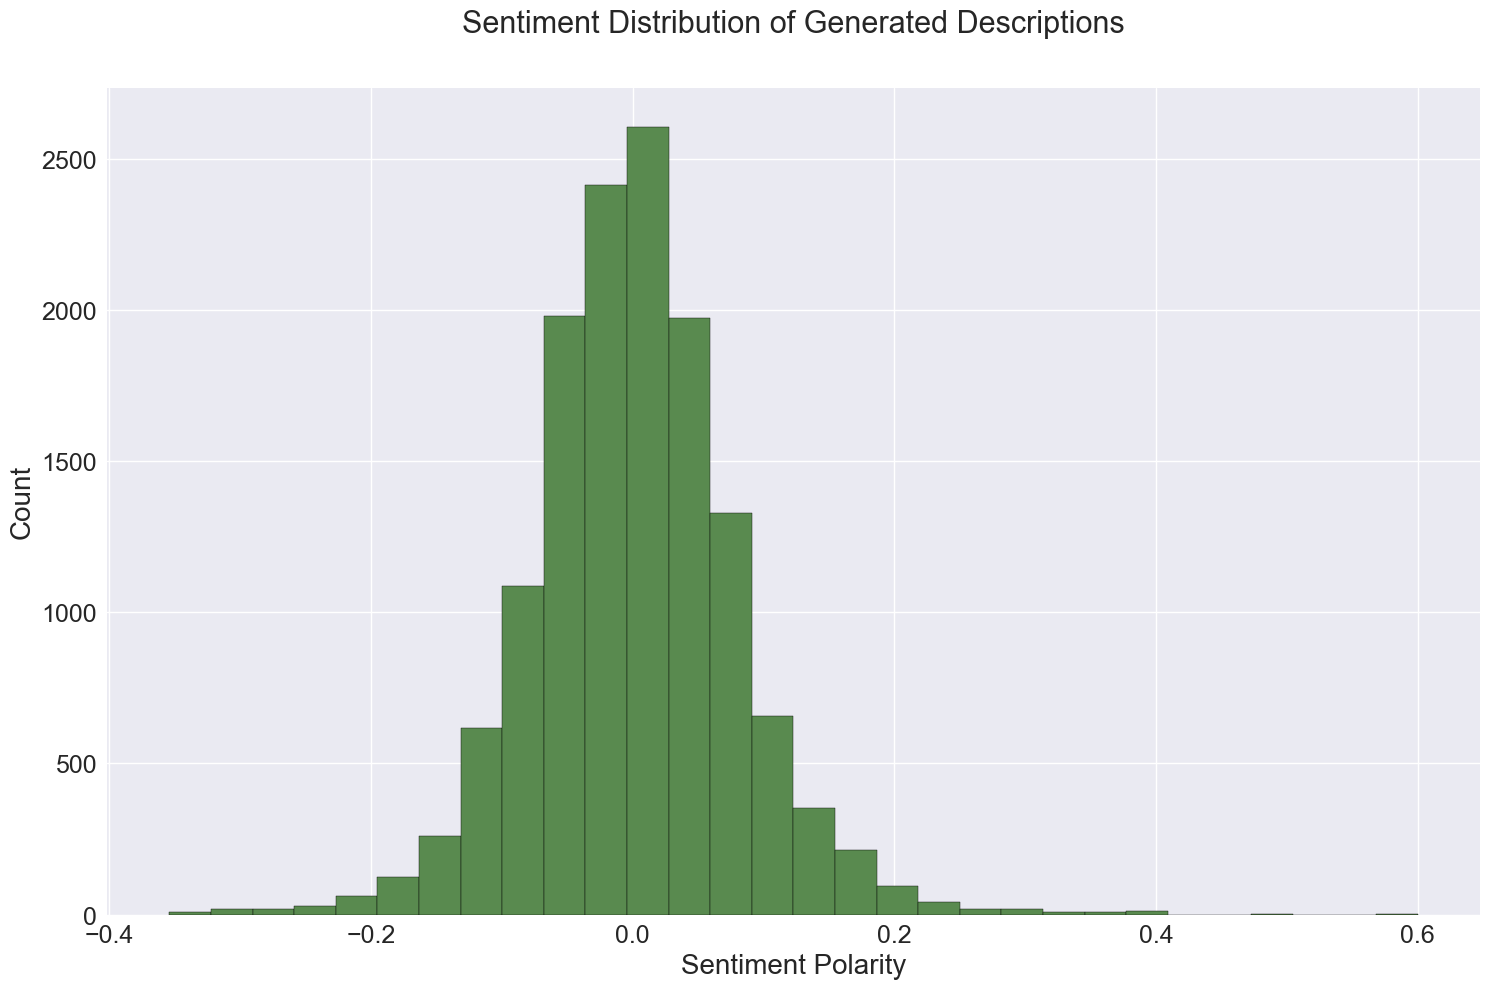

In [89]:
sentiment_by_chapter = analyze_sentiment_generated(content_df, column='generated_description_processed')

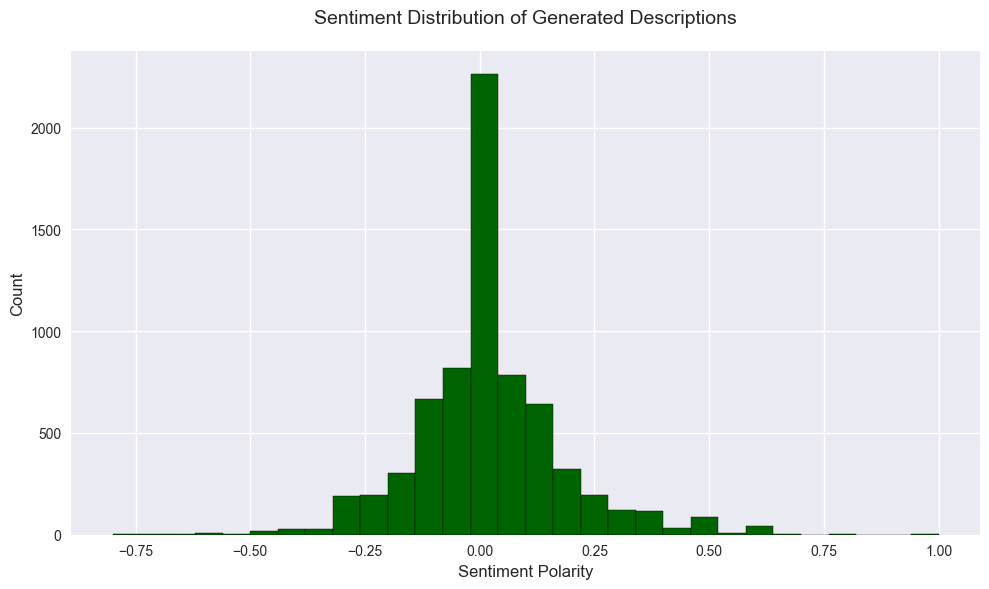

In [141]:
sentiment_by_chapter = analyze_sentiment_generated(content_df, column='definition_processed')

### Topic Modelling

In [121]:
topic_df = overlap_df

def run_lda_topic_modeling(df: pd.DataFrame, n_topics: int = 4, text_col: str = 'generated_description_processed'):
    """
    Run LDA topic modeling on preprocessed text and analyze topic distribution per chapter.
    
    Args:
        df: DataFrame with preprocessed text and 'chapter' columns
        n_topics: Number of topics to extract (default=4)
        text_col: Column name containing the preprocessed text
    
    Returns:
        chapter_topic_props: DataFrame with topic proportions per chapter
        topic_words_table: DataFrame with top 20 words per topic and their counts
    """
    # Set plot style
    plt.style.use('seaborn-v0_8')
    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFA500']  # Bright red, green, blue, orange
    
    # Vectorize the text
    vectorizer = CountVectorizer()
    doc_term_matrix = vectorizer.fit_transform(df[text_col].fillna(''))
    
    # Fit LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(doc_term_matrix)
    
    # Get topic-word distributions
    feature_names = np.array(vectorizer.get_feature_names_out())
    topic_word_counts = lda.components_
    
    # Table: Top 5 words per topic with counts
    topic_words = []
    for topic_idx, topic_dist in enumerate(topic_word_counts):
        top_indices = topic_dist.argsort()[::-1][:20]
        for i in top_indices:
            topic_words.append({
                'Topic': f'Topic {topic_idx+1}',
                'Word': feature_names[i],
                'Count': int(topic_dist[i])
            })
    
    # Fix deprecated groupby.apply warning by explicitly selecting columns
    topic_words_df = pd.DataFrame(topic_words)
    topic_words_table = (topic_words_df.groupby('Topic', group_keys=False)
                        .apply(lambda x: x.nlargest(20, 'Count'))
                        .reset_index(drop=True))
    
    # Get document-topic distributions
    doc_topic_dist = lda.transform(doc_term_matrix)
    topic_cols = [f'Topic {i+1}' for i in range(n_topics)]
    doc_topic_df = pd.DataFrame(doc_topic_dist, columns=topic_cols)
    doc_topic_df['chapter'] = df['chapter'].values
    
    # Aggregate topic proportions per chapter
    chapter_topic_props = doc_topic_df.groupby('chapter')[topic_cols].mean()
    chapter_topic_props = chapter_topic_props.div(chapter_topic_props.sum(axis=1), axis=0)  # Normalize to proportions
    
    # Plot: Stacked bar chart of topic proportions per chapter
    plt.figure(figsize=(14, 7))
    bottom = np.zeros(len(chapter_topic_props))
    chapters = chapter_topic_props.index.astype(str)
    for i, topic in enumerate(topic_cols):
        plt.bar(
            chapters,
            chapter_topic_props[topic],
            bottom=bottom,
            color=colors[i % len(colors)],
            label=topic
        )
        bottom += chapter_topic_props[topic].values
    plt.xlabel('Chapter', fontsize=12)
    plt.ylabel('Proportion of Words', fontsize=12)
    plt.title('LDA Topic Proportions per Chapter', fontsize=14, pad=20)
    plt.legend(title='Topic', bbox_to_anchor=(0.5, 1.15), loc='center', ncol=4)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return chapter_topic_props, topic_words_table

/var/folders/7g/y1r4j5314tj34x7tn5g1cdg80000gn/T/ipykernel_92305/977804978.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(20, 'Count'))


,Topic,Word,Count
0,Topic 1,symptom,6420
1,Topic 1,may,4195
2,Topic 1,cause,4004
3,Topic 1,diagnosis,3946
4,Topic 1,condition,3855
...,...,...,...
75,Topic 4,combination,1984
76,Topic 4,made,1983
77,Topic 4,disease,1960
78,Topic 4,blood,1926


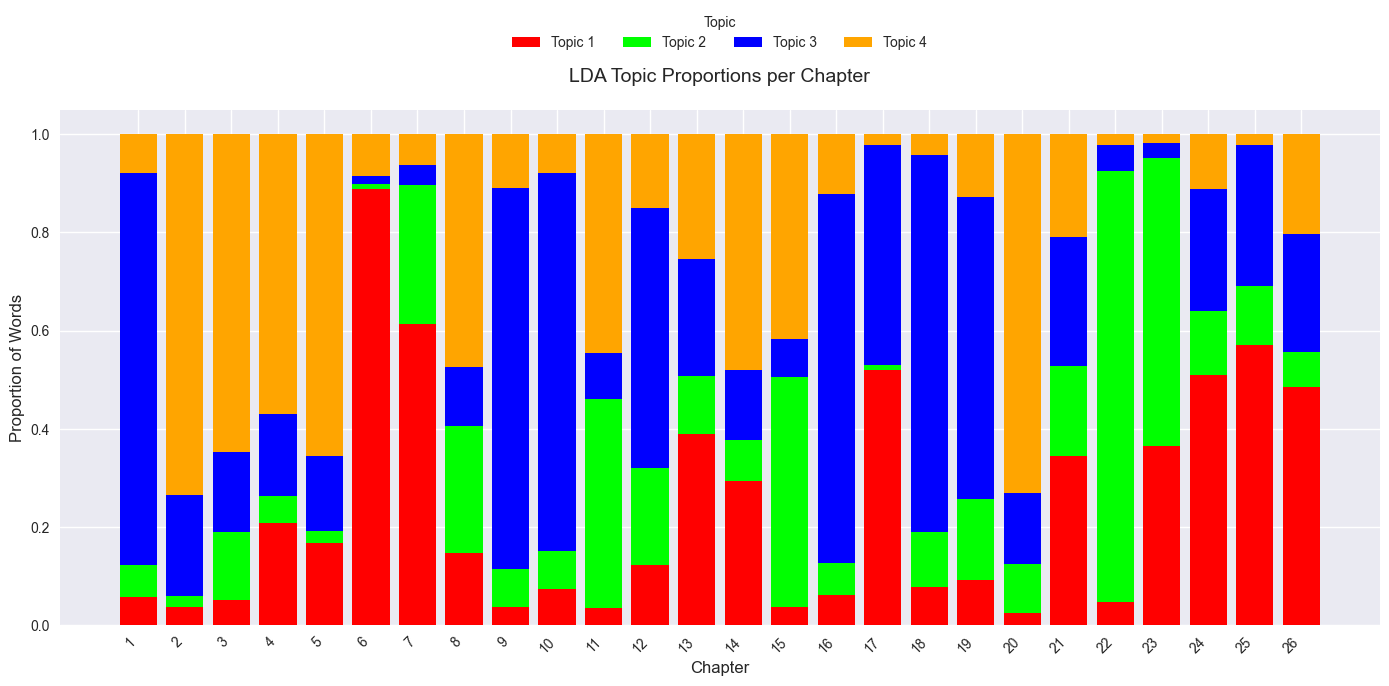

In [122]:
chapter_topic_props, topic_words_table = run_lda_topic_modeling(topic_df)

In [130]:
# Reshape the table to have 20 rows with 4 topics side by side
pd.DataFrame({
    'Topic 1': topic_words_table[topic_words_table['Topic'] == 'Topic 1'][['Word', 'Count']].values.tolist(),
    'Topic 2': topic_words_table[topic_words_table['Topic'] == 'Topic 2'][['Word', 'Count']].values.tolist(),
    'Topic 3': topic_words_table[topic_words_table['Topic'] == 'Topic 3'][['Word', 'Count']].values.tolist(),
    'Topic 4': topic_words_table[topic_words_table['Topic'] == 'Topic 4'][['Word', 'Count']].values.tolist()
}).map(lambda x: f"{x[0]} ({x[1]})" if isinstance(x, list) else x)

,Topic 1,Topic 2,Topic 3,Topic 4
0,symptom (6420),injury (6214),symptom (5221),symptom (4987)
1,may (4195),symptom (4309),infection (4857),disorder (4454)
2,cause (4004),diagnosis (3623),include (4313),may (4347)
3,diagnosis (3946),may (3507),condition (4204),genetic (4336)
4,condition (3855),pain (3154),may (4165),condition (4332)
5,disorder (3300),include (2980),diagnosis (4104),diagnosis (4013)
6,include (2983),cause (2934),cause (3716),cause (3769)
7,medical (2863),physical (2765),typically (3247),include (3662)
8,individual (2555),imaging (2649),test (3220),typically (3407)
9,person (2539),trauma (2546),examination (2433),person (2777)


## Domain-specific

### Aetiology

In [92]:
def analyze_aetiology_degree(df: pd.DataFrame, text_col: str = 'generated_description') -> pd.DataFrame:
    """
    Analyze the degree of aetiology (medical causal reasoning) in generated descriptions
    using a dictionary of causal/logical operators, and plot their frequency per entire description, 
    across all chapters.
    
    Args:
        df: DataFrame with 'chapter' and generated description columns
        text_col: Column name containing the preprocessed text
    
    Returns:
        DataFrame with frequency of causal words per chapter
    """
    # Set plot style
    plt.style.use('seaborn-v0_8')
    colors = ['#598A4F', '#8FBC8F', '#2E8B57']
    
    # Define aetiology/causal dictionary (expand as needed)
    causal_words = [
        'because', 'due to', 'as a result', 'therefore', 'thus', 'consequently', 'leads to', 'results in',
        'causes', 'cause', 'caused by', 'resulting in', 'since', 'so that', 'hence', 'attributable to',
        'secondary to', 'induced by', 'triggered by', 'associated with', 'linked to', 'responsible for'
    ]
    
    # Lowercase and join multi-word expressions for matching
    causal_words = [w.lower() for w in causal_words]
    
    def count_causal_phrases(text):
        if pd.isna(text):
            return 0
        text = str(text).lower()
        count = 0
        for phrase in causal_words:
            count += text.count(phrase)
        return count
    
    # Count causal words/phrases in each description
    df['causal_count'] = df[text_col].apply(count_causal_phrases)
    
    # Aggregate by chapter (mean and sum)
    chapter_causal = df.groupby('chapter')['causal_count'].agg(['mean', 'sum']).reset_index()
    
    # Plot: mean causal word frequency per chapter
    plt.figure(figsize=(15, 9))
    sns.barplot(
        data=chapter_causal,
        x='chapter',
        y='mean',
        color=colors[0],
        edgecolor='#000000'
    )
    plt.xlabel('Chapter', fontsize=18)
    plt.ylabel('Mean Causal Word Frequency', fontsize=18)
    plt.title('Degree of Aetiology in Original and Generated Descriptions by Chapter', fontsize=22, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    
    return chapter_causal

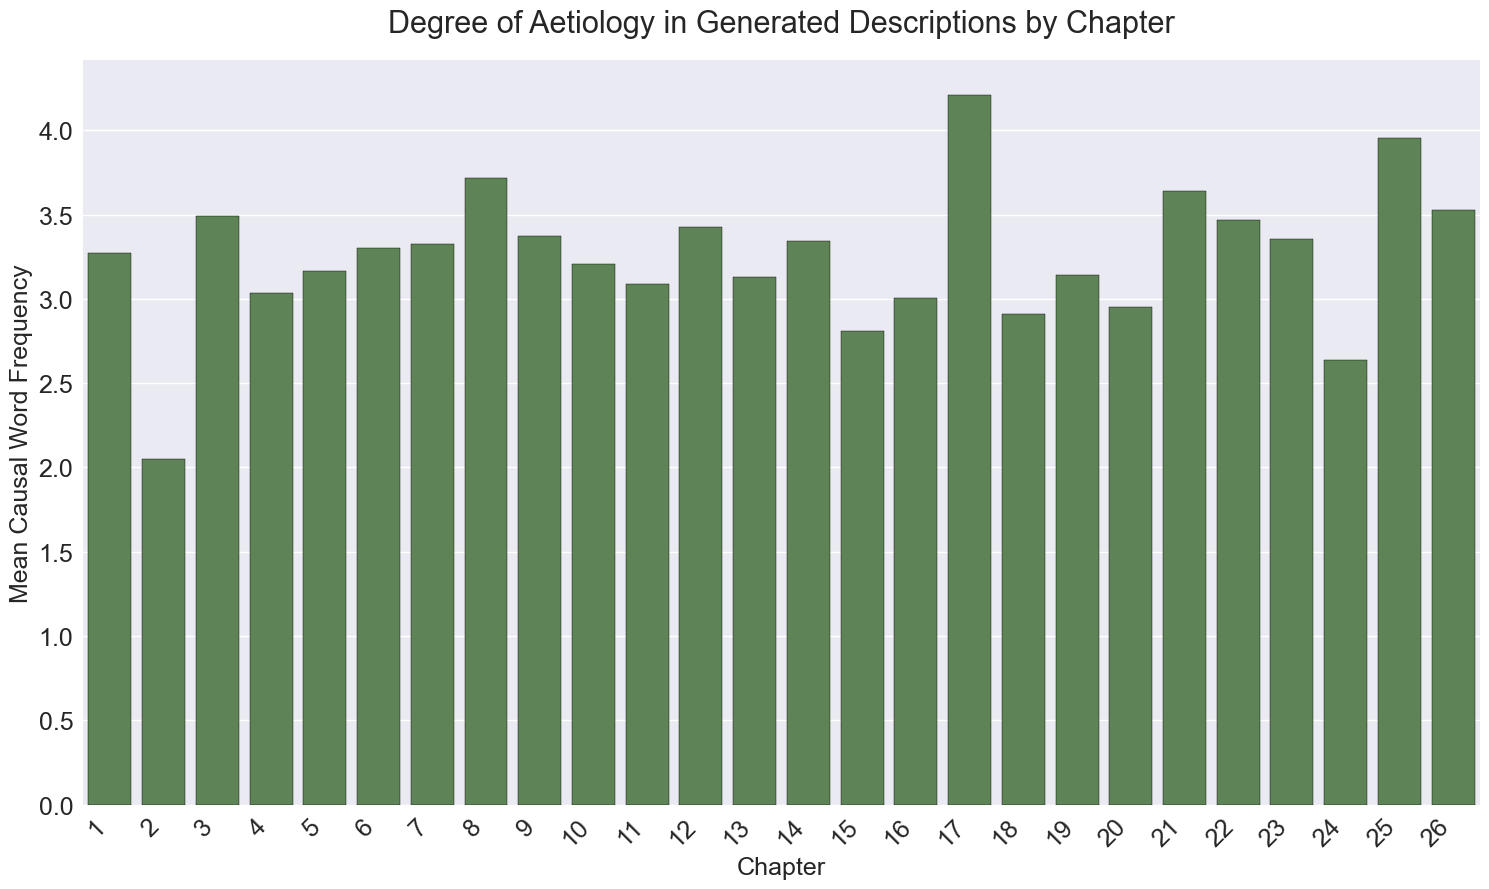

In [91]:
causal_analysis = analyze_aetiology_degree(content_df, text_col = 'generated_description')

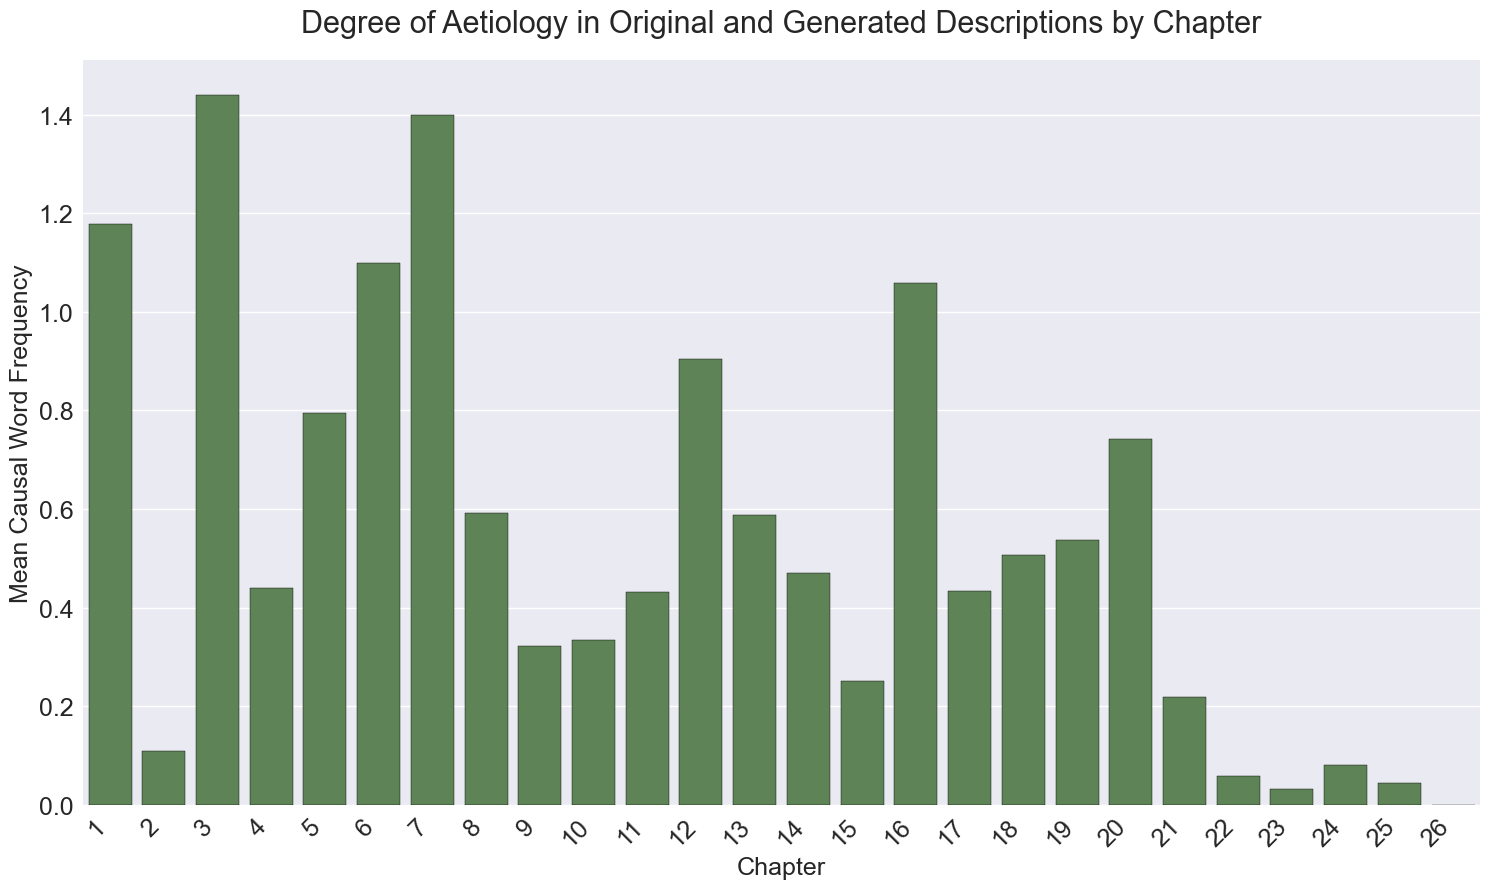

In [93]:
causal_analysis = analyze_aetiology_degree(content_df, text_col = 'definition')

### Description Segmentation

In [94]:
segment_df = overlap_df

In [106]:
def segment_description(text: str) -> dict:
    """
    Segment a description into components based on sentence content.
    Args:
        text: The full description text
    Returns:
        Dictionary with component lengths and sentences
    """
    if pd.isna(text) or not str(text).strip():
        return {
            'causes_len': 0,
            'symptoms_len': 0, 
            'transmission_len': 0,
            'diagnosis_len': 0,
            'treatment_len': 0
        }
    
    # Keywords for each component - made more specific to avoid over-categorization
    components = {
        'causes': ['caused by', 'due to', 'results from', 'triggered by', 'risk factors include', 'etiology', 'caused when', 'develops from', 'occurs when', 'associated with', 'linked to', 'contributing factors', 'predisposing factors', 'secondary to', 'consequence of', 'stems from'],
        'symptoms': ['symptoms include', 'signs include', 'manifests as', 'clinical features', 'characterized by', 'presents with', 'presentation includes', 'marked by', 'features include', 'typically shows', 'commonly presents', 'hallmark features', 'classic signs', 'manifestations include', 'clinical presentation', 'patients experience', 'associated symptoms'],
        'transmission': ['transmitted through', 'spreads via', 'contracted through', 'mode of transmission', 'infectious spread', 'contagious through', 'passed through', 'transmitted by', 'spread occurs', 'transmission occurs', 'can spread', 'vector-borne', 'person-to-person', 'direct contact', 'airborne transmission', 'vertical transmission'],
        'diagnosis': ['diagnosed through', 'detected by', 'assessment includes', 'evaluated using', 'diagnostic tests', 'identified by', 'confirmed by', 'diagnosis requires', 'testing reveals', 'diagnostic criteria', 'screening tests', 'clinical evaluation', 'laboratory findings', 'imaging shows', 'examination reveals', 'diagnostic workup'],
        'treatment': ['treated with', 'therapy includes', 'managed by', 'interventions include', 'care involves', 'treatment options', 'therapeutic approach', 'management includes', 'standard treatment', 'treatment consists', 'medical management', 'therapeutic interventions', 'treatment strategy', 'clinical management', 'supportive care', 'treatment protocol']
    }
    
    # Split into sentences more robustly
    text = str(text)
    sentences = []
    current_sentence = ""
    
    for char in text:
        current_sentence += char
        if char in '.!?':
            if current_sentence.strip():
                sentences.append(current_sentence.strip())
            current_sentence = ""
    
    if current_sentence.strip():
        sentences.append(current_sentence.strip())
    
    # Initialize component lengths
    component_lengths = {f'{c}_len': 0 for c in components.keys()}
    
    # Categorize each sentence, allowing multiple categories per sentence
    for sentence in sentences:
        sentence = sentence.lower()
        sentence_length = len(word_tokenize(sentence))
        
        # Track if sentence was categorized at all
        categories_found = 0
        
        # Check each component's keywords
        for comp, keywords in components.items():
            if any(kw.lower() in sentence for kw in keywords):
                component_lengths[f'{comp}_len'] += sentence_length
                categories_found += 1
        
        # If sentence matches multiple categories, divide its length among them
        if categories_found > 1:
            for comp in components.keys():
                if component_lengths[f'{comp}_len'] > 0:
                    component_lengths[f'{comp}_len'] = component_lengths[f'{comp}_len'] // categories_found
                
    return component_lengths

def analyze_information_component_distribution(df: pd.DataFrame, text_col: str = 'generated_description') -> pd.DataFrame:
    """
    Analyze and plot distribution of information components across chapters.
    Args:
        df: DataFrame with chapter and description columns
        text_col: Column name containing the description
    Returns:
        DataFrame with component proportions by chapter
    """
    # Set plot style
    plt.style.use('seaborn-v0_8')
    colors = ['#598A4F', '#5959E3', '#D2B48C', '#FF6F61', '#AE65D6']
    
    # Get component lengths for each description
    component_lengths = df[text_col].apply(segment_description)
    component_df = pd.DataFrame(list(component_lengths))
    
    # Add chapter info
    component_df['chapter'] = df['chapter'].values
    
    # Calculate total length and proportions
    length_cols = [col for col in component_df.columns if col.endswith('_len')]
    component_df['total_len'] = component_df[length_cols].sum(axis=1)
    
    for col in length_cols:
        prop_col = col.replace('_len', '_prop')
        component_df[prop_col] = component_df[col] / component_df['total_len'].where(component_df['total_len'] > 0, 1)
        
    # Aggregate by chapter
    prop_cols = [col for col in component_df.columns if col.endswith('_prop')]
    chapter_props = component_df.groupby('chapter')[prop_cols].mean()
    
    # Plot stacked bar chart
    plt.figure(figsize=(16, 10))
    bottom = np.zeros(len(chapter_props))
    chapters = chapter_props.index.astype(str)
    
    for i, col in enumerate(prop_cols):
        component = col.replace('_prop', '').capitalize()
        plt.bar(
            chapters,
            chapter_props[col],
            bottom=bottom,
            color=colors[i % len(colors)],
            label=component
        )
        bottom += chapter_props[col].values
        
    plt.xlabel('Chapter', fontsize=20)
    plt.ylabel('Proportion of Description', fontsize=20)
    plt.title('Distribution of Information Components by Chapter', fontsize=22, pad=20)
    plt.legend(title='Component', bbox_to_anchor=(0.5, -0.22), loc='center', ncol=3, fontsize=20, title_fontsize=20)
    plt.xticks(rotation=45, ha='right', fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    
    return chapter_props

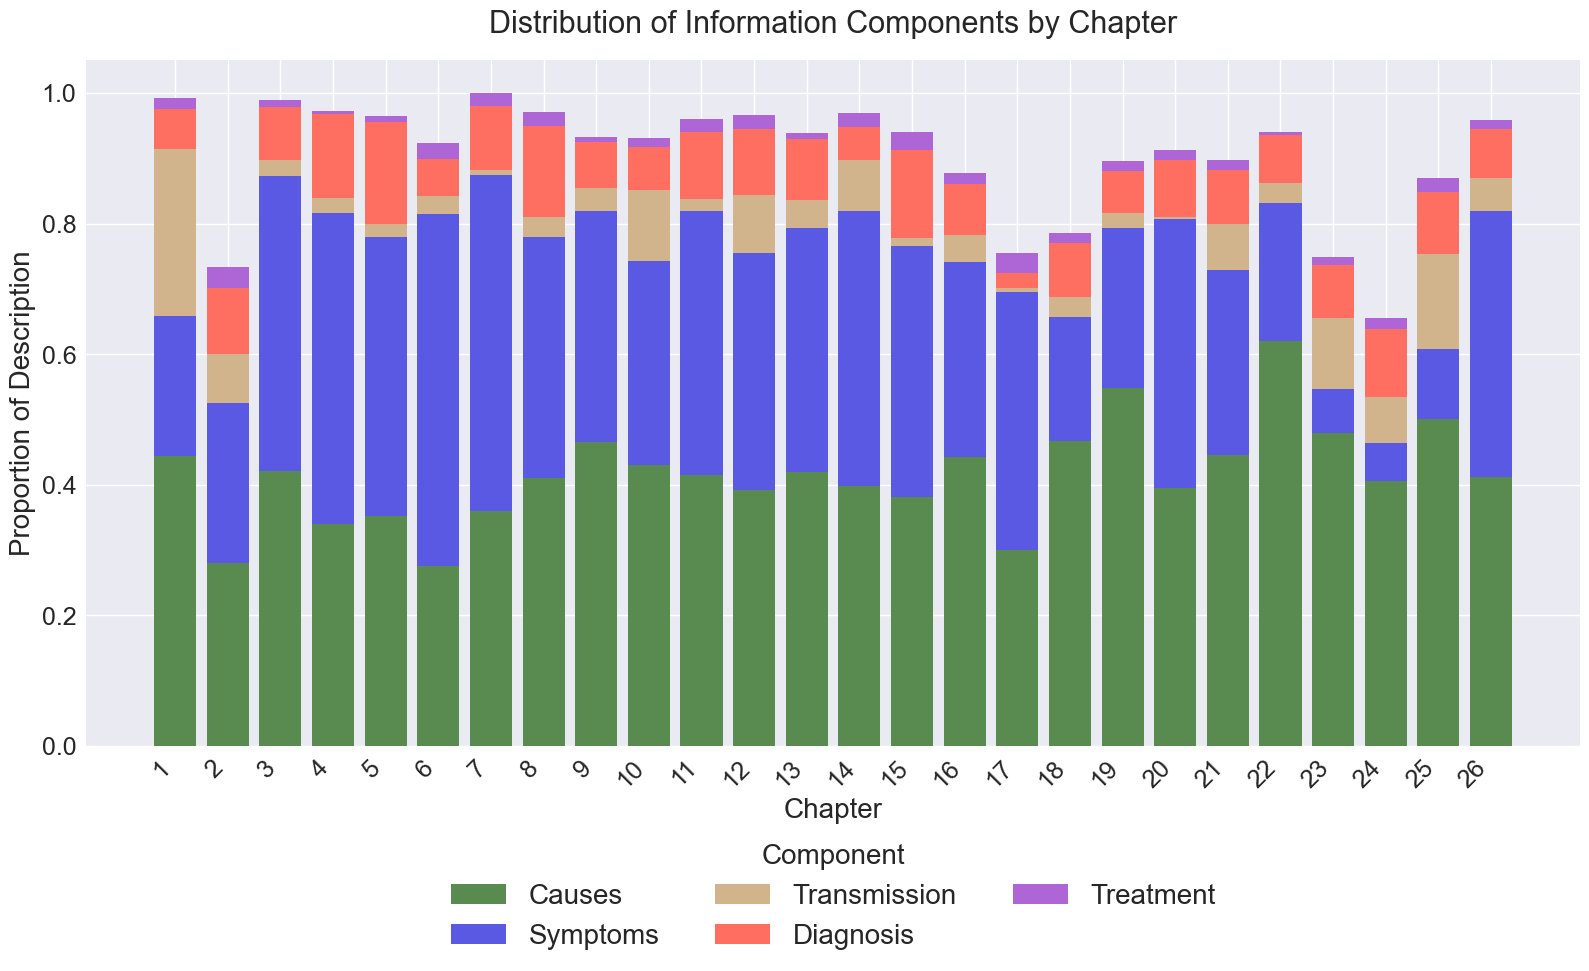

In [107]:
segmenting = analyze_information_component_distribution(content_df, text_col ='generated_description_processed')

### Axes-expansion

In [110]:
def keyword_axis_score(text, pos_keywords, neg_keywords):
    """
    Compute a normalized axis score for a text based on positive and negative keyword counts.
    Returns a score in [-1, 1].
    """
    if pd.isna(text) or not str(text).strip():
        return 0.0
    text = str(text).lower()
    
    # Count positive keywords and negated negative keywords
    pos_count = sum(text.count(kw) for kw in pos_keywords)
    pos_count += sum(text.count(f"not {kw}") + text.count(f"non-{kw}") + text.count(f"non {kw}") for kw in neg_keywords)
    
    # Count negative keywords and negated positive keywords  
    neg_count = sum(text.count(kw) for kw in neg_keywords)
    neg_count += sum(text.count(f"not {kw}") + text.count(f"non-{kw}") + text.count(f"non {kw}") for kw in pos_keywords)
    
    total = pos_count + neg_count
    if total == 0:
        return 0.0
    return (pos_count - neg_count) / total

def analyze_axes_expansion(
    df: pd.DataFrame, 
    text_col: str = 'generated_description'
) -> dict:
    """
    Analyze and plot chapters/diseases along semantic axes using keyword-based scoring.
    Returns a dictionary of DataFrames with axis scores per chapter.
    """
    # Set plot style
    plt.style.use('seaborn-v0_8')
    colors = ['#598A4F', '#D2B48C', '#FF6F61']
    
    # Define axes and keywords
    axes = {
        'etiology': {
            'positive': ['infectious', 'bacterial', 'viral', 'fungal', 'parasitic', 'transmissible',
                        'pathogen', 'microorganism', 'infection', 'contagious', 'epidemic', 'pandemic', 'vector'],
            'negative': ['genetic', 'hereditary', 'congenital', 'inherited', 'chromosomal', 'mutation',
                        'familial', 'germline', 'autosomal', 'recessive', 'dominant', 'allele', 'genome', 'dna']
        },
        'location': {
            'positive': ['external', 'skin', 'surface', 'superficial', 'cutaneous', 'epidermal', 'trauma',
                        'dermal', 'exterior', 'outer', 'visible', 'exposed', 'topical', 'peripheral'],
            'negative': ['internal', 'organ', 'systemic', 'visceral', 'deep', 'intrinsic',
                        'endogenous', 'core', 'central', 'interior', 'underlying', 'embedded', 'innate']
        },
        'timing': {
            'positive': ['chronic', 'persistent', 'long-term', 'lifelong', 'permanent', 'irreversible',
                        'progressive', 'degenerative', 'continuous', 'ongoing', 'sustained', 'prolonged'],
            'negative': ['acute', 'short-term', 'transient', 'temporary', 'reversible',
                        'intermittent', 'brief', 'episodic', 'sudden', 'rapid', 'quick', 'immediate']
        },
        'involvement': {
            'positive': ['systemic', 'widespread', 'generalized', 'multiple organs', 'multi-organ', 'full body',
                        'throughout body', 'diffuse', 'disseminated', 'constitutional', 'whole body', 'system-wide',
                        'involving', 'affecting', 'encompassing', 'pervasive', 'extensive', 'many', 'numerous',
                        'multiple systems', 'multi-system', 'body-wide', 'comprehensive', 'global'],
            'negative': ['localized', 'focal', 'specific organ', 'single organ', 'isolated', 'confined',
                        'limited to', 'restricted to', 'contained', 'site-specific', 'regional', 'targeted',
                        'solitary', 'discrete', 'circumscribed', 'bounded', 'only', 'specifically',
                        'exclusively', 'solely', 'particularly', 'precisely', 'exactly', 'uniquely',
                        'distinctly', 'locally', 'narrowly', 'strictly', 'explicitly', 'singularly']
        },
        'symptomatology': {
            'positive': ['pain', 'ache', 'soreness', 'discomfort', 'tenderness', 'burning',
                        'throbbing', 'stabbing', 'cramping', 'spasm', 'painful'],
            'negative': ['dysfunction', 'impairment', 'deficit', 'weakness', 'disability',
                        'limitation', 'restricted', 'reduced', 'loss', 'inability', 'compromised']
        }
    }
    
    # Compute axis scores for each description
    for axis_name, keywords in axes.items():
        df[f'{axis_name}_axis'] = df[text_col].apply(
            lambda x: keyword_axis_score(x, keywords['positive'], keywords['negative'])
        )
    
    # Aggregate mean axis scores by chapter
    axis_cols = [f'{axis}_axis' for axis in axes.keys()]
    chapter_axes = df.groupby('chapter')[axis_cols].mean().reset_index()
    
    # Plot 1D: Etiology axis
    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=chapter_axes,
        x='chapter',
        y='etiology_axis',
        color=colors[0],
        edgecolor='black'
    )
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Chapter', fontsize=20)
    plt.ylabel('Etiology Axis\n(+ Infectious, - Genetic)', fontsize=20)
    plt.title('Etiology Axis by Chapter', fontsize=22, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()
    
    # Function to create 2D comparison plot
    def plot_2d_comparison(x_axis, y_axis, x_label, y_label, title):
        plt.figure(figsize=(16, 13))
        
        x_values = chapter_axes[f'{x_axis}_axis']
        y_values = chapter_axes[f'{y_axis}_axis']
        
        # Calculate axis limits with 10% margin
        x_margin = (x_values.max() - x_values.min()) * 0.1
        y_margin = (y_values.max() - y_values.min()) * 0.1
        
        x_min = x_values.min() - x_margin
        x_max = x_values.max() + x_margin
        y_min = y_values.min() - y_margin
        y_max = y_values.max() + y_margin
        
        # Create scatter plot
        plt.scatter(
            x_values,
            y_values,
            c=colors[0],
            s=100,
            edgecolor='black'
        )
        
        # Add chapter labels
        for i, row in chapter_axes.iterrows():
            plt.annotate(
                str(int(row['chapter'])),
                (row[f'{x_axis}_axis'], row[f'{y_axis}_axis']),
                xytext=(5, 5),
                textcoords='offset points',
                color='black',
                fontsize=20,
                weight='bold'
            )
        
        # Add axis lines
        plt.axhline(0, color='black', linestyle='--', linewidth=1)
        plt.axvline(0, color='black', linestyle='--', linewidth=1)
        
        # Add extreme labels at the edges of the plot with more spacing
        plt.text(x_max + x_margin*0.5, 0, x_label.split(',')[0].strip(), ha='left', va='center', fontsize=20)
        plt.text(x_min - x_margin*0.5, 0, x_label.split(',')[1].strip(), ha='right', va='center', fontsize=20)
        plt.text(0, y_max + y_margin*0.5, y_label.split(',')[0].strip(), ha='center', va='bottom', fontsize=20)
        plt.text(0, y_min - y_margin*0.5, y_label.split(',')[1].strip(), ha='center', va='top', fontsize=20)
        
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel(x_label, fontsize=20)
        plt.ylabel(y_label, fontsize=20)
        plt.title(title, fontsize=22, pad=20)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.tight_layout()
        plt.show()
    
    # Create 2D plots
    plot_2d_comparison(
        'location', 'timing',
        '+ External, - Internal',
        '+ Long-term, - Short-term',
        'Location vs Timing Axes by Chapter'
    )
    
    plot_2d_comparison(
        'involvement', 'symptomatology',
        '+ Systemic, - Localized',
        '+ Pain, - Dysfunction',
        'Involvement vs Symptomatology Axes by Chapter'
    )
    
    return {
        'chapter_axes': chapter_axes
    }

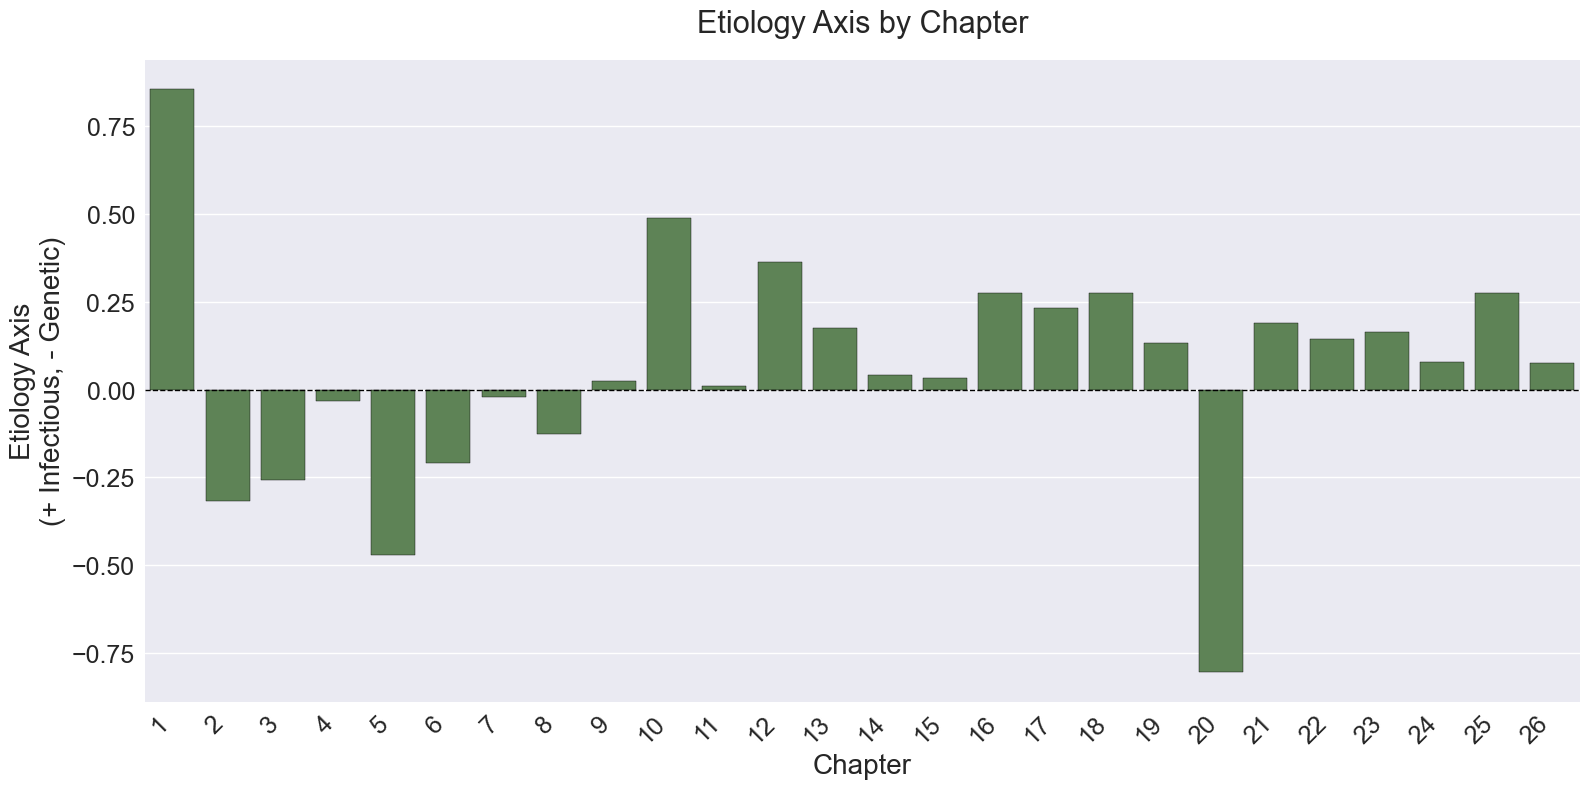

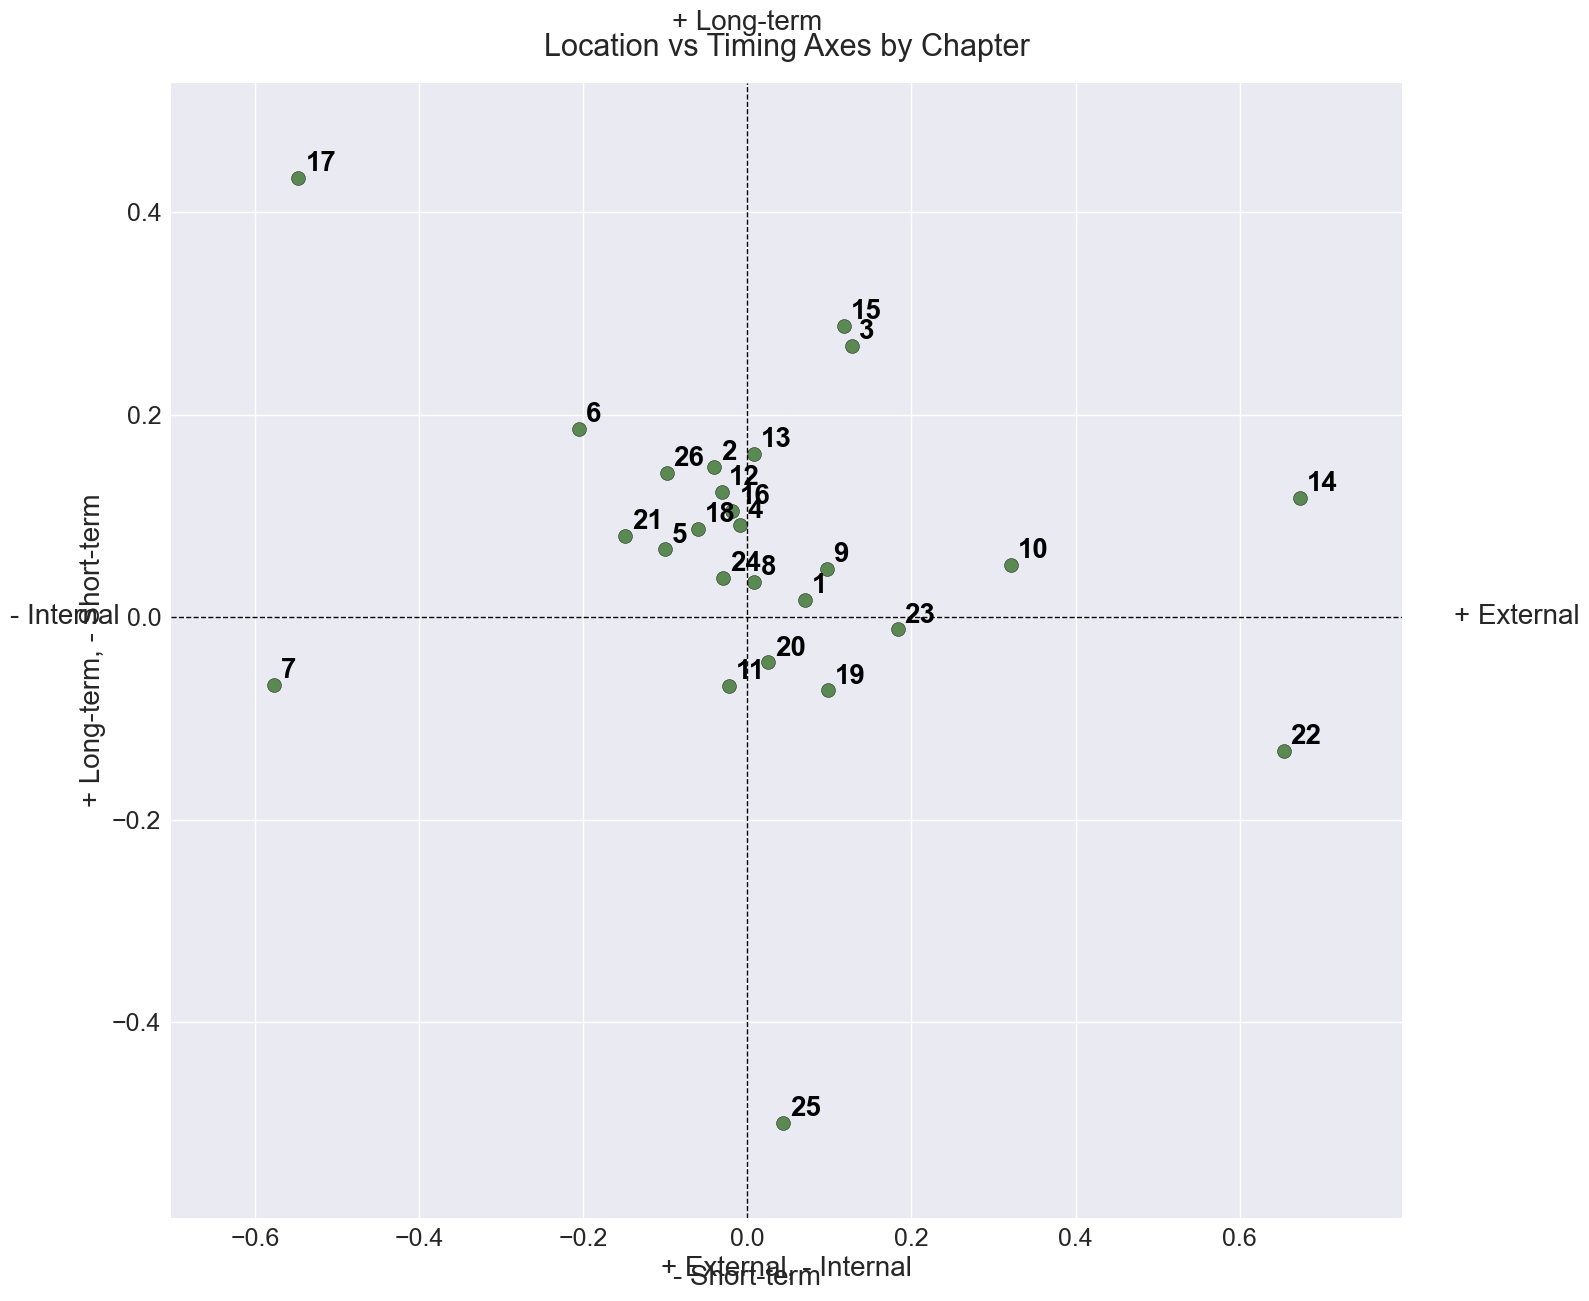

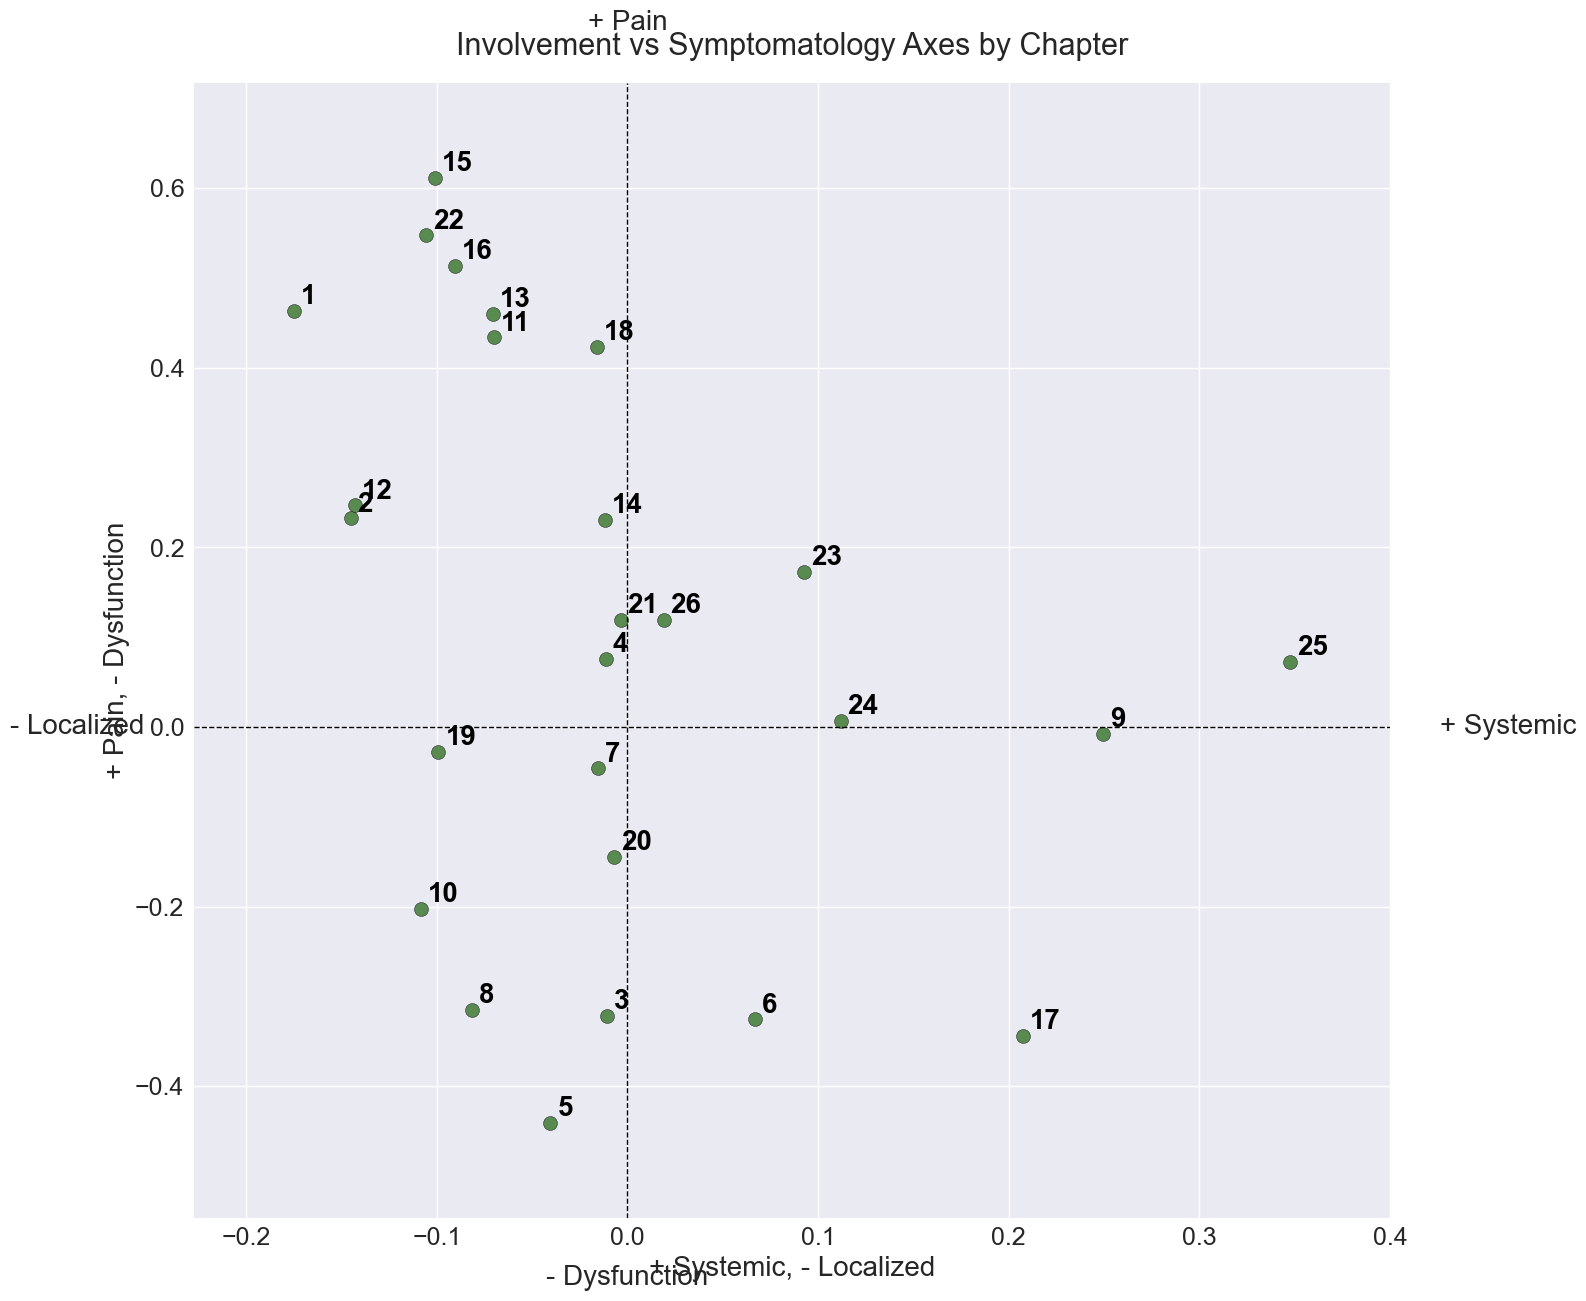

In [111]:
axes = analyze_axes_expansion(df = content_df, text_col = 'generated_description_processed')

### Coverage by body part

In [119]:
def body_part_treemap(
    df: pd.DataFrame,
    text_col: str = 'generated_description',
    body_parts_dict: dict = None
):
    """
    Create a nested treemap of body part coverage based on description length.
    
    Args:
        df: DataFrame with disease descriptions.
        text_col: Column containing the text descriptions.
        body_parts_dict: Dictionary mapping body part names to lists of key terms.
    """
    # Default body part dictionary if not provided
    if body_parts_dict is None:
        body_parts_dict = {
            'Brain': ['brain', 'cerebral', 'cranial', 'neural', 'nervous'],
            'Head/Face': ['head', 'skull', 'scalp', 'face', 'eye', 'ear', 'mouth', 'nasal'],
            'Neck/Throat': ['neck', 'throat', 'larynx', 'pharynx', 'thyroid', 'cervical'],
            'Chest/Lungs': ['chest', 'lung', 'thorax', 'bronch', 'pleura', 'respiratory'],
            'Heart/Vessels': ['heart', 'cardiac', 'artery', 'vein', 'vascular', 'aorta'],
            'Abdomen/Digestive': ['abdomen', 'stomach', 'liver', 'intestin', 'colon', 'bowel', 'pancreas', 'gallbladder', 'digestive'],
            'Kidneys/Urinary': ['kidney', 'renal', 'bladder', 'urinary', 'ureter', 'urethra'],
            'Genital/Reproductive': ['genital', 'testis', 'ovary', 'uterus', 'prostate', 'reproductive', 'vagina', 'penis'],
            'Musculoskeletal': ['muscle', 'bone', 'joint', 'spine', 'skeletal', 'cartilage', 'ligament', 'tendon'],
            'Skin/Subcutaneous': ['skin', 'cutaneous', 'derma', 'epidermis', 'subcutaneous'],
            'Limbs/Extremities': ['arm', 'leg', 'hand', 'foot', 'finger', 'toe', 'extremity', 'limb']
        }
    
    # Assign each description to a body part
    def assign_body_part(text):
        if pd.isna(text) or not str(text).strip():
            return 'Unclassified'
        text = str(text).lower()
        for part, keywords in body_parts_dict.items():
            if any(kw in text for kw in keywords):
                return part
        return 'Unclassified'
    
    df['body_part'] = df[text_col].apply(assign_body_part)
    
    # Group by body part
    grouped = df.groupby('body_part').agg(
        total_text_size=(text_col, lambda x: sum(len(str(t).split()) for t in x)),
        num_diseases=(text_col, 'count')
    ).reset_index()
    
    # Remove unclassified if present
    grouped = grouped[grouped['body_part'] != 'Unclassified']
    
    # Sort for better treemap layout
    grouped = grouped.sort_values('total_text_size', ascending=False)
    
    # Treemap
    plt.figure(figsize=(16, 9))
    colors = plt.cm.Set2.colors  # More saturated color palette
    
    # Create labels with consistent font size
    labels = [
        f"{row['body_part']}\n" + \
        f"Words: {row['total_text_size']:,}\n" + \
        f"Diseases: {row['num_diseases']:,}"
        for _, row in grouped.iterrows()
    ]
    
    squarify.plot(
        sizes=grouped['total_text_size'],
        label=labels,
        color=colors[:len(grouped)],
        alpha=0.9,
        text_kwargs={'fontsize': 13, 'color': 'black'}  # Use single consistent font size
    )
    plt.title('Body Part Coverage in Disease Descriptions', fontsize=18, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

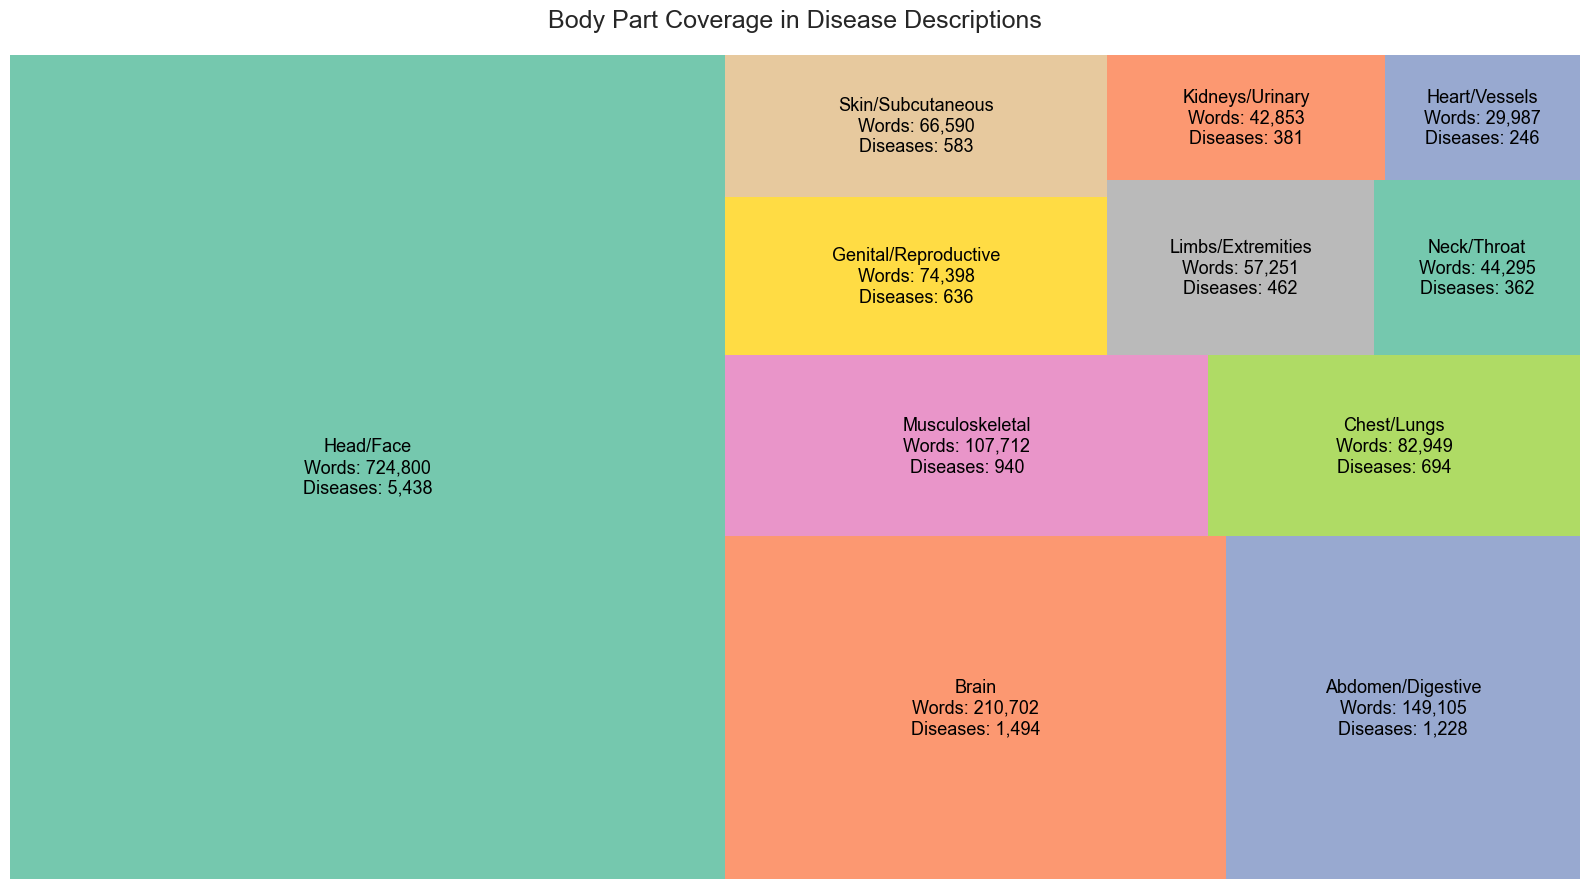

In [120]:
body_part_treemap(content_df)

# Hierarchy Analysis

# Preparing for embeddings

In [38]:
dg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13960 entries, 0 to 13959
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           13960 non-null  int64 
 1   code                         13062 non-null  object
 2   title                        13960 non-null  object
 3   browser_url                  13960 non-null  object
 4   class_kind                   13960 non-null  object
 5   definition                   6894 non-null   object
 6   parent                       13960 non-null  int64 
 7   inclusions                   1113 non-null   object
 8   foundation_children          1468 non-null   object
 9   foundation_child_references  1468 non-null   object
 10  index_terms                  10855 non-null  object
 11  related_entities             2287 non-null   object
 12  full_text                    13960 non-null  object
 13  children                     32

In [50]:
dv = dg[['id', 'chapter', 'code', 'title', 'generated_description', 'inclusions', 'related_entities', 'children', 'exclusions']].copy()

In [70]:
def create_vectorization_text(df):
    # Create a copy of the dataframe
    df_vector = df.copy()
    
    # Create a dictionary for quick title lookup
    title_lookup = dict(zip(df['id'], df['title']))
    
    def process_row(row):
        # Start with the generated description
        vector_text = row['generated_description']
        
        # Get the condition name from title
        condition_name = row['title']
        
        # Process inclusions if available
        if pd.notna(row['inclusions']):
            # Split inclusions into list and clean
            inclusion_terms = [term.strip() for term in row['inclusions'].split(';')]
            # Filter out terms already in the description
            new_terms = [term for term in inclusion_terms 
                        if term.lower() not in vector_text.lower()]
            if new_terms:
                vector_text += f"\n{condition_name} includes the following diagnostic terms and synonyms: {', '.join(new_terms)}."
        
            # Process related entities if available
        if pd.notna(row['related_entities']):
            # Split related entities into list and clean
            related_ids = [id.strip() for id in row['related_entities'].split(';')]
            # Get titles for each ID
            related_titles = [title_lookup.get(int(id), '') for id in related_ids if id]
            related_titles = [title for title in related_titles if title]  # Remove empty strings
            # Filter out titles that are already mentioned in the text
            new_related_titles = [title for title in related_titles 
                                if title.lower() not in vector_text.lower()]
            if new_related_titles:
                vector_text += f"\n{condition_name} is clinically related to: {', '.join(new_related_titles)}."
        
        # Process children if available
        if pd.notna(row['children']):
            # Split children into list and clean
            child_ids = [id.strip() for id in row['children'].split(';')]
            # Get titles for each ID
            child_titles = [title_lookup.get(int(id), '') for id in child_ids if id and id not in ('other', 'unspecified')]
            child_titles = [title for title in child_titles if title]  # Remove empty strings
            if child_titles:
                vector_text += f"\n{condition_name} is a parent category that includes the following specific conditions: {', '.join(child_titles)}."
        
        # Process exclusions if available
        if pd.notna(row['exclusions']):
            # Split exclusions into list and clean
            exclusion_terms = [term.strip() for term in row['exclusions'].split(';')]
            # Filter out terms already in the description
            new_terms = [term for term in exclusion_terms 
                        if term.lower() not in vector_text.lower()]
            if new_terms:
                vector_text += f"\nTerms that are not categorized under {condition_name} are: {', '.join(new_terms)}."
        
        return vector_text
    
    # Apply the processing function to each row
    df_vector['vectorization_text'] = df_vector.apply(process_row, axis=1)
    
    return df_vector

In [73]:
df_with_vectorization = create_vectorization_text(dv)[['id', 'chapter', 'code', 'title', 'vectorization_text']]

In [76]:
df_with_vectorization.to_csv('icd11-25_data_vectorization.csv')